#Подготовка


In [1]:
import os, sys

from keras.engine import Input
from keras.engine import Model
from keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D, Concatenate, LSTM, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import nltk

from timeit import default_timer as timer

import csv
import re
import random
from random import randint

from random import shuffle

import numpy as np
from nltk.corpus import stopwords

# Download russian stop-words
nltk.download('stopwords')

# Download dataset
!wget --continue -O /content/data.csv https://www.dropbox.com/s/xsrdgu293i8ie86/data.csv?dl=0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [5]:
import pandas as pd 
  
# Read IND_data.csv into a DataFrame, assigned to df 
months1 = pd.read_csv("months1.csv", sep=';', encoding='cp1251') 
months2 = pd.read_csv("months2.csv", sep=';', encoding='cp1251') 
df = months1.append(months2)
df = df.reset_index()
# Prints the first 5 rows of a DataFrame as default 
df.head() 
pd.options.display.max_columns = 999
# Prints no. of rows and columns of a DataFrame 
df[['НомерЗаказаНаСайте', 'Телефон_new']].nunique()

НомерЗаказаНаСайте    369812
Телефон_new           222284
dtype: int64

In [6]:
from keras.models import model_from_json

K.set_learning_phase(0)
with open(os.path.join('model.json'), 'r') as fp:
    model = model_from_json(fp.read())

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.load_weights(os.path.join('model.h5'))

def format_out(out, dict):
    stringify = np.vectorize(lambda x: '{}: {:0.2f}'.format(dict[x], out[x]))
    return ', '.join(stringify(np.argsort(-out)))
    return ""

def predict(m, word):
    out = m.predict(np.array([word2input(word, 50)]))
    indMax = np.argmax(out[0])
    return SEX_DICT_REVERSE[indMax]

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [7]:
letters = "@ABCDEFGHIJKLMNOPQRSTUVWXYZАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789.,!? -"
LETTERS_FOR_RANDOM = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789.,!?    -"
dictSize = len(letters)
maxlen = 50
print("Total letters: " + str(dictSize))

SEX_DICT = {'unknown': 0, 'Мужчины': 1, 'Женщины': 2}
SEX_DICT_REVERSE = {0: 'unknown', 1: 'Мужчины', 2: 'Женщины'}


def sparse(n, size):
    out = [0.0] * size
    if int(n) >= size:
        print("{} {}".format(n, size))
    out[int(n)] = 1.0
    return out

def chartoindex(c):
    c = c.upper()
    if (c not in letters):
        print("Incorrect letter: " + c)
        return 0
    return letters.index(c)


def word2input(word, maxsize):
    word = word.upper()
    word = re.sub('[^0-9A-ZА-Я ]+', '', word)
    input = list(map(lambda c: sparse(chartoindex(c), dictSize), word.upper().replace(" ", "")))
    input += [sparse(dictSize - 1, dictSize)] * (maxsize - len(input))
    return list(input)

def loadFile(file):
    with open(file, encoding='utf-8') as fp:
        data = csv.reader(fp, delimiter=',')
        data = list(data)
        return data

def getPatch(data, count):
    print("Preparing dataSet...")
    max_input = 0
    sexOutput = list()
    input = list()
    stopWords = stopwords.words('russian')
    counter = 0

    shuffle(data)
    for row in data:
        if (counter > count):
            break
        if (row[3].strip() in SEX_DICT ):
            max_input = max(max_input, len(row[0]))

            r = randint(0, 10)
            r2 = randint(0, 1)
            if r < 7:
                if r == 0:
                    text = row[1].strip()
                elif r < 4:
                    if (r2 == 0):
                        text = (row[0] + " " + row[1] + " " + row[2]).strip()
                    else:
                        text = (row[1] + " " + row[0] + " " + row[2]).strip()
                elif r < 6:
                    if (r2 == 0):
                        text = (row[0] + " " + row[1]).strip()
                    else:
                        text = (row[1] + " " + row[0]).strip()
                else:
                    if (r2 == 0):
                        text = (row[1] + " " + row[2]).strip()
                    else:
                        text = (row[2] + " " + row[1]).strip()

                if len(text) < maxlen:
                    input.append(word2input(text, maxlen))
                    sexOutput.append(sparse(SEX_DICT[row[3].strip()], len(SEX_DICT)))
            else:
                if r == 7:
                    text = random.choice(stopWords)
                elif r == 8:
                    text = random.choice(stopWords) + " " + random.choice(stopWords)
                elif r == 9: # Random string
                    N = r = randint(2, 15)
                    text = ''.join(random.choices(LETTERS_FOR_RANDOM, k=N))
                else:
                    text = random.choice(stopWords) + " " + random.choice(stopWords) + " " + random.choice(stopWords)
                text = text.strip().upper()
                if len(text) < maxlen:
                    input.append(word2input(text, maxlen))
                    sexOutput.append(sparse(SEX_DICT["unknown"], len(SEX_DICT)))

            counter += 1
            if (counter % 30000 == 0):
                print(text)

    x = np.array(input)
    x = x.astype('float32')
    slices = [int(0.8 * len(x)), len(x)]
    x_train, x_test, _ = np.split(x, slices)
    action_output_train, action_output_test,            _ = np.split(sexOutput, slices)

    return [x_train, x_test,
            action_output_train, action_output_test]

Total letters: 76


#@Преобразование данных


Добавление пола

In [8]:
gender = pd.DataFrame()
gender['Клиент'] = df['Клиент'].unique()
gender['Пол'] = gender.apply(lambda x: 'Гость' if str(x.Клиент)=='Гость' else predict(model, str(x.Клиент)), axis = 1)
gender = gender.set_index('Клиент')
gender = gender.to_dict()['Пол']
df['Пол'] = df.apply(lambda x: gender[x.Клиент], axis = 1)

Удаление ненужных столбцов

In [9]:
df.drop(columns=['ГородМагазина', 'МагазинЗаказа'])

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,Группа2,Группа3,Группа4,Тип,Номенклатура,ТипТовара,Отменено,ПричинаОтмены,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,ГодДатыЗаказа,ПВЗ_код,Статус,Гео,Маржа,СуммаУслуг,СуммаДоставки,НомерСтроки,КоличествоПроданоКлиенту,ДатаЗаказаНаСайте,Телефон_new,ЭлектроннаяПочта_new,Клиент,ID_SKU,Пол
0,0,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"МАТЭКО, НОСКИ (зелен), р. 12-14",МГТ,Нет,NaN,1,50,50,"23,1",7,2 017,901000646,Доставлен,Москва,"26,9",49,49,3,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00051334048,Женщины
1,1,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"МАТЭКО, НОСКИ (т.син), р. 12-14",МГТ,Нет,NaN,1,50,50,"23,1",7,2 017,901000646,Доставлен,Москва,"26,9",49,49,4,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00051367351,Женщины
2,2,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"ЗАЙКА МОЯ, НОСКИ дет., р. 14",МГТ,Нет,NaN,1,49,49,"40,96",7,2 017,901000646,Доставлен,Москва,"8,04",49,49,7,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00007611755,Женщины
3,3,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"ЗАЙКА МОЯ, НОСКИ дет., р. 14",МГТ,Нет,NaN,1,40,40,"34,21",7,2 017,901000646,Доставлен,Москва,"5,79",49,49,1,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00014478250,Женщины
4,4,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,колготки,ОДЕЖДА,"ЗАЙКА МОЯ, КОЛГОТКИ дет., р. 92-98",МГТ,Нет,NaN,1,169,169,"105,21",7,2 017,901000646,Доставлен,Москва,"63,79",49,49,9,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00001209351,Женщины
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673262,876070,31.10.2017 23:59,02.11.2017 0:00,6005071_ES,К отгрузке,3 222,3 222,Курьерская,Наличная,Москва,КОСМЕТИКА/ГИГИЕНА,СРЕДСТВА БЫТОВОЙ ХИМИИ,кондиционеры для белья,ППКП,"BURTI, ОПОЛАСКИВАТЕЛЬ с запахом розы, (1,5 л)",МГТ,Нет,NaN,2,297,594,253,10,2 017,NaN,Доставлен,Москва,88,150,150,3,2,31.10.2017 0:00,55574953-52575355515475,109117_mu19@inbox.ru,Мария,IDL00039538654,Женщины
1673263,876071,31.10.2017 23:59,02.11.2017 0:00,6005071_ES,К отгрузке,3 222,3 222,Курьерская,Наличная,Москва,КОСМЕТИКА/ГИГИЕНА,СРЕДСТВА БЫТОВОЙ ХИМИИ,кондиционеры для белья,ППКП,"BURTI, ОПОЛАСКИВАТЕЛЬ с запахом лаванды, (1,5 л)",МГТ,Нет,NaN,2,281,562,253,10,2 017,NaN,Доставлен,Москва,56,150,150,2,2,31.10.2017 0:00,55574953-52575355515475,109117_mu19@inbox.ru,Мария,IDL00039538755,Женщины
1673264,876072,31.10.2017 23:59,03.11.2017 0:00,6005077_ES,Возврат из ПВЗ,2 564,2 564,Магазины,Безналичная,Москва,ИГРУШКИ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"треки, парковки",ИГРУШКИ,"HOT WHEELS, НАБОР стартовый Конструктор трасс",МГТ,Нет,NaN,1,2 564,2 564,2 233,10,2 017,23111,Возврат,Москва,331,0,0,1,0,31.10.2017 0:00,55574857-54545754565577,97117_au19@mail.ru,Дмитрий,IDL00043615553,Мужчины
1673265,876073,31.10.2017 23:59,03.11.2017 0:00,6005089_ES,Возврат из ПВЗ,2 564,2 564,Магазины,Безналичная,Москва,ИГРУШКИ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"треки, парковки",ИГРУШКИ,"HOT WHEELS, НАБОР стартовый Конструктор трасс",МГТ,Нет,NaN,1,2 564,2 564,2 233,10,2 017,23111,Возврат,Москва,331,0,0,1,0,31.10.2017 0:00,55574857-54545754565577,97117_au19@mail.ru,Дмитрий,IDL00043615553,Мужчины


Преобразование номенклатуры 'Доставка'

In [10]:
delivery_cheque = df[df.Номенклатура == 'Доставка'].НомерЗаказаНаСайте.to_list()
delivery_cheque = pd.DataFrame(data=delivery_cheque)
delivery_cheque[1] = 1
delivery_cheque
df = df.merge(delivery_cheque, left_on = 'НомерЗаказаНаСайте', right_on = 0, how = 'left')
df = df.drop(columns=[0])
df = df.rename(columns={1:'Доставка'})
df = df.fillna(0)

In [11]:
df

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,Группа2,Группа3,Группа4,Тип,Номенклатура,ТипТовара,Отменено,ПричинаОтмены,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,ГодДатыЗаказа,ПВЗ_код,Статус,Гео,Маржа,СуммаУслуг,СуммаДоставки,НомерСтроки,КоличествоПроданоКлиенту,ДатаЗаказаНаСайте,Телефон_new,ЭлектроннаяПочта_new,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка
0,0,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"МАТЭКО, НОСКИ (зелен), р. 12-14",МГТ,Нет,0,1,50,50,"23,1",7,2 017,901000646,Доставлен,Москва,"26,9",49,49,3,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00051334048,0,0,Женщины,1.0
1,1,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"МАТЭКО, НОСКИ (т.син), р. 12-14",МГТ,Нет,0,1,50,50,"23,1",7,2 017,901000646,Доставлен,Москва,"26,9",49,49,4,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00051367351,0,0,Женщины,1.0
2,2,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"ЗАЙКА МОЯ, НОСКИ дет., р. 14",МГТ,Нет,0,1,49,49,"40,96",7,2 017,901000646,Доставлен,Москва,"8,04",49,49,7,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00007611755,0,0,Женщины,1.0
3,3,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,носки,ОДЕЖДА,"ЗАЙКА МОЯ, НОСКИ дет., р. 14",МГТ,Нет,0,1,40,40,"34,21",7,2 017,901000646,Доставлен,Москва,"5,79",49,49,1,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00014478250,0,0,Женщины,1.0
4,4,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1 634,1 634,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКИЕ КОЛГОТКИ И НОСКИ,колготки,ОДЕЖДА,"ЗАЙКА МОЯ, КОЛГОТКИ дет., р. 92-98",МГТ,Нет,0,1,169,169,"105,21",7,2 017,901000646,Доставлен,Москва,"63,79",49,49,9,1,30.06.2017 0:00,55574948-52495050484877,116117_tu17@mail.ru,Татьяна,IDL00001209351,0,0,Женщины,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673347,876070,31.10.2017 23:59,02.11.2017 0:00,6005071_ES,К отгрузке,3 222,3 222,Курьерская,Наличная,Москва,КОСМЕТИКА/ГИГИЕНА,СРЕДСТВА БЫТОВОЙ ХИМИИ,кондиционеры для белья,ППКП,"BURTI, ОПОЛАСКИВАТЕЛЬ с запахом розы, (1,5 л)",МГТ,Нет,0,2,297,594,253,10,2 017,0,Доставлен,Москва,88,150,150,3,2,31.10.2017 0:00,55574953-52575355515475,109117_mu19@inbox.ru,Мария,IDL00039538654,0,0,Женщины,1.0
1673348,876071,31.10.2017 23:59,02.11.2017 0:00,6005071_ES,К отгрузке,3 222,3 222,Курьерская,Наличная,Москва,КОСМЕТИКА/ГИГИЕНА,СРЕДСТВА БЫТОВОЙ ХИМИИ,кондиционеры для белья,ППКП,"BURTI, ОПОЛАСКИВАТЕЛЬ с запахом лаванды, (1,5 л)",МГТ,Нет,0,2,281,562,253,10,2 017,0,Доставлен,Москва,56,150,150,2,2,31.10.2017 0:00,55574953-52575355515475,109117_mu19@inbox.ru,Мария,IDL00039538755,0,0,Женщины,1.0
1673349,876072,31.10.2017 23:59,03.11.2017 0:00,6005077_ES,Возврат из ПВЗ,2 564,2 564,Магазины,Безналичная,Москва,ИГРУШКИ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"треки, парковки",ИГРУШКИ,"HOT WHEELS, НАБОР стартовый Конструктор трасс",МГТ,Нет,0,1,2 564,2 564,2 233,10,2 017,23111,Возврат,Москва,331,0,0,1,0,31.10.2017 0:00,55574857-54545754565577,97117_au19@mail.ru,Дмитрий,IDL00043615553,0,0,Мужчины,0.0
1673350,876073,31.10.2017 23:59,03.11.2017 0:00,6005089_ES,Возврат из ПВЗ,2 564,2 564,Магазины,Безналичная,Москва,ИГРУШКИ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"треки, парковки",ИГРУШКИ,"HOT WHEELS, НАБОР стартовый Конструктор трасс",МГТ,Нет,0,1,2 564,2 564,2 233,10,2 017,23111,Возврат,Москва,331,0,0,1,0,31.10.2017 0:00,55574857-54545754565577,97117_au19@mail.ru,Дмитрий,IDL00

In [12]:
region = pd.read_excel("goroda.xlsx", sheet_name='зп+население')
df = df.merge(region[['address', 'dolgota']], left_on=['Регион'], right_on=[region.columns.values[1]], how='left')
df = df.rename(columns={'address':'РегионЗона'})
df = df.drop(columns=['dolgota'],axis=1)

In [13]:
df['РегионЗона'].value_counts()

Москва                                      729725
Санкт-Петербург                             111749
Нижегородская область                        40111
Краснодарский край                           31539
Самарская область                            28330
Свердловская область                         25822
Ростовская область                           24039
Тульская область                             23952
Республика Татарстан                         22317
Воронежская область                          22163
Республика Башкортостан                      21036
Калужская область                            18178
Пермский край                                18106
Волгоградская область                        17549
Челябинская область                          17359
Ханты-Мансийский автономный округ — Югра     16617
Новосибирская область                        15453
Тюменская область                            14887
Саратовская область                          14495
Рязанская область              

Добавление параметра производителя

In [14]:
df['Компания'] = df.apply(lambda x: x.Номенклатура.replace('.', ',').split(',')[0] , axis = 1)

In [15]:
df['Маржа'] = df['Маржа'].astype(str)
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(',', '.'))
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(' ', ''))
df['Маржа'] = df['Маржа'].astype(float)

In [16]:
df['СуммаСтроки'] = df['СуммаСтроки'].astype(str)
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(',', '.'))
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(' ', ''))
df['СуммаСтроки'] = df['СуммаСтроки'].astype(float)

In [17]:
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(str)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(',', '.'))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(' ', ''))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(float)

In [18]:
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].astype(str)
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].apply(lambda x: x.replace(',', '.'))
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].apply(lambda x: x.replace(' ', ''))
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].astype(float)

In [19]:
df['Цена'] = df['Цена'].astype(str)
df['Цена'] = df['Цена'].apply(lambda x: x.replace(',', '.'))
df['Цена'] = df['Цена'].apply(lambda x: x.replace(' ', ''))
df['Цена'] = df['Цена'].astype(float)

In [20]:
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(str)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(',', '.'))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(' ', ''))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(float)

Удаление подозрительных строк

In [21]:
df = df.drop(df[df.Телефон_new == '0'].index)
df = df.drop(df[df.ПричинаОтмены == '1.4 Ошибка выбора, будет новый заказ'].index)
df = df.drop(df[df.ПричинаОтмены == '1.1 Тест, контрольная закупка'].index)
df = df.drop(df[df.Маржа == 0].index)
df = df.drop(df[df.СуммаДокумента == 0].index)
df = df.drop(df[df.Количество == 0].index)
df = df.drop(df[df.НовыйСтатус  == 'Отменен'].index)
df = df.drop(df[df.НовыйСтатус  == 'Отменяется'].index)
df = df.drop(df[df.НовыйСтатус  == 'Расформирован ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'Принят в ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'В резерве'].index)
df = df.drop(df[df.НовыйСтатус  == 'Частичный возврат'].index)
df = df.drop(df[df.НовыйСтатус  == 'Скомплектован Регион'].index)
df = df.drop(df[df.НовыйСтатус  == 'Возврат'].index)
df = df.drop(df[df.НовыйСтатус  == 'Отправлен в ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'Комплектация Регион'].index)
df = df.drop(df[df.НовыйСтатус  == 'Передан в Регион'].index)
df = df[df['РегионЗона'].notna()]
df = df[df['Маржа'].notna()]
df = df[df['Группа2'].notna()]
df = df[df['Группа3'].notna()]
df = df[df['Группа4'].notna()]
df = df[df['Регион'].notna()]
df = df[df['Цена'].notna()]
df = df[df['СуммаСтроки'].notna()]
df = df[df['ЦенаЗакупки'].notna()]
df = df.drop(df[df.Маржа < -1000].index)
df = df.drop(df[df.Маржа > 10000].index)
df = df.drop(df[df.Цена < 10].index)
df = df.drop(df[df.Количество > 20].index)
df = df.drop_duplicates()

In [23]:
df[['НомерЗаказаНаСайте', 'Телефон_new']].nunique()

НомерЗаказаНаСайте    262994
Телефон_new           171254
dtype: int64

#Исследование данных

In [71]:
df.drop_duplicates(subset=['Телефон_new'])['Пол'].value_counts()

Гость      95056
Женщины    61633
Мужчины     9562
unknown     5003
Name: Пол, dtype: int64

In [72]:
df['Телефон_new'].value_counts()

55574857-56565349525677    446
55574954-57485351535070    444
55574954-54555249514877    418
55575052-51525457495772    414
55575055-51485353525070    341
                          ... 
55574954-54544949555477      1
55575351-55515655515176      1
55574850-52525250495077      1
55575055-50535655505270      1
55574851-48514948525375      1
Name: Телефон_new, Length: 171254, dtype: int64

In [73]:
df.drop_duplicates(subset=['НомерЗаказаНаСайте'])['МетодДоставки'].value_counts()

Магазины                 212330
Курьерская                40817
Самовывоз                  6540
Pick point                 1975
DPD                        1260
Транспортная компания        72
Name: МетодДоставки, dtype: int64

In [74]:
df['НовыйСтатус'].value_counts()

Доставлен         477577
К отгрузке        256761
Возврат из ПВЗ    229211
Не обеспечен          31
Name: НовыйСтатус, dtype: int64

In [75]:
df['МаржаПроцентная'] = (df['СуммаСтроки'] - (df['ЦенаЗакупки'] * df['Количество']))/df['СуммаСтроки']

Исследование данных по компаниям

In [76]:
companies = df['Компания'].value_counts().to_frame()
companies = companies.drop(companies[companies.Компания < 1].index)
companies['Название'] = companies.index
companies = companies.reset_index(drop=True)
companies.rename(columns={"Компания": "ПроданоТоваров"}, inplace=True)

In [77]:
companies['МаржаСредняя'] = companies.apply(lambda x: df[df.Компания == x.Название].Маржа.mean(axis=0), axis = 1)

In [78]:
df = df.drop(df[df['МаржаПроцентная'] == -np.inf].index)

In [79]:
companies.to_csv('компании.csv', sep=';', encoding='cp1251')

In [80]:
df['Маржа'].astype(float).sum()

177353132.98999995

In [81]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#Сводники

**По месяцам**

*Размещенные товары*

Выручка, маржа, количество

In [82]:
df.groupby('МесяцДатыЗаказа').sum()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная
МесяцДатыЗаказа,,,,,,,,,,,
7,41131183002,1000525566.00000,316736,162371444.47000,184640761.65000,129872525.97999,34148084.53000,1263337,279513,212179.00000,39261.48443
8,142139618242,1113506139.00000,350082,180291557.53000,201782020.88000,144870472.28000,37198186.05000,1500286,305313,239906.00000,41130.92441
9,43677501934,1086563307.00000,341058,183627281.00000,209550034.00000,140872296.27000,44819371.01000,1325097,301306,216972.00000,43218.72484
10,176766251747,1371573343.00000,414974,241701322.00000,269657819.00000,182587510.39998,61187491.40001,1598614,362514,225231.00000,52915.62028


Выручка

In [83]:
df['СуммаСтроки'].sum()

865630635.53

Маржа

In [84]:
df['Маржа'].sum()

177353132.98999995

Количество

In [85]:
df['Количество'].sum()

1422850

Уникальные заказы, уникальные клиенты

In [86]:
df.groupby('МесяцДатыЗаказа').nunique()

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,...,ЭлектроннаяПочта_new,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка,РегионЗона,Компания,МаржаПроцентная
МесяцДатыЗаказа,,,,,,,,,,,,,,,,,,,,,
7,214982,9143,73,57551,3,9923,10085,6,2,180,...,4133,1794,56804,1,1,4,2,72,4965,55002
8,240737,9604,70,63511,3,10405,10240,6,2,186,...,4361,1965,63707,1,1,4,2,74,5322,61699
9,220819,9473,70,61780,4,10823,10446,6,2,183,...,4365,1957,58667,1,1,4,2,72,5444,58490
10,277771,8833,73,80152,4,11787,11310,6,2,189,...,4749,2214,70678,1,1,4,2,73,5953,69858


Уникальные заказы, уникальные клиенты

In [87]:
df.nunique()

index                       693985
Дата                         37053
ДатаДоставки                   167
НомерЗаказаНаСайте          262994
НовыйСтатус                      4
СуммаЗаказаНаСайте           17641
СуммаДокумента               17463
МетодДоставки                    6
ФормаОплаты                      2
Регион                         275
Группа2                         13
Группа3                         97
Группа4                        441
Тип                              5
Номенклатура                108991
ТипТовара                        2
Отменено                         2
ПричинаОтмены                   24
Количество                      20
Цена                         12132
СуммаСтроки                  13002
ЦенаЗакупки                  33636
МесяцДатыЗаказа                  4
ГодДатыЗаказа                    1
ПВЗ_код                          5
Статус                           3
Гео                              2
Маржа                        54750
СуммаУслуг          

Маржа процентная


In [88]:
df.groupby('МесяцДатыЗаказа').mean()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная
МесяцДатыЗаказа,,,,,,,,,,,
7,189214.15133,4602.67812,1.45707,746.95092,849.39558,597.44744,157.09008,5.81168,1.28583,0.97608,0.18061
8,584109.81262,4575.85204,1.43863,740.89173,829.20483,595.33201,152.86256,6.16529,1.25466,0.98587,0.16902
9,196065.45735,4877.51181,1.53099,824.29089,940.65643,632.36655,201.19123,5.94827,1.35254,0.97397,0.19401
10,631111.94646,4896.95467,1.48159,862.95088,962.76449,651.89570,218.45888,5.70756,1.29429,0.80415,0.18893


Маржа процентная


In [89]:
df['МаржаПроцентная'].mean()

0.1831988563070701

Средний чек

In [90]:
df.drop_duplicates(subset=['НомерЗаказаНаСайте']).groupby('МесяцДатыЗаказа').mean()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная
МесяцДатыЗаказа,,,,,,,,,,,
7,189029.06909,3361.65074,1.40296,1528.51360,1722.21782,1209.22052,332.27771,2.43150,1.20151,0.95712,0.18253
8,588904.98068,3352.99024,1.35723,1532.38425,1693.07079,1227.44099,317.58493,2.47976,1.14369,0.97238,0.17039
9,197800.33323,3596.01413,1.44458,1643.08961,1848.05693,1270.87257,387.87841,2.36568,1.22137,0.96012,0.20063
10,635285.82628,3582.22155,1.39877,1646.81983,1816.84331,1245.15895,414.81965,2.30306,1.17660,0.80875,0.20168


Средний чек

In [91]:
df.drop_duplicates(subset=['НомерЗаказаНаСайте'])['СуммаЗаказаНаСайте'].mean()

3481.836467752116

Среднее количество товаров

In [92]:
df[df['МесяцДатыЗаказа'] == 7].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

5.503570745947073

Среднее количество товаров

In [93]:
df[df['МесяцДатыЗаказа'] == 8].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

5.512147502007526

Среднее количество товаров

In [94]:
df.groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

5.410199472231306

*Выкупленные товары*

In [95]:
df_bought = df[df.КоличествоПроданоКлиенту != 0]
df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']

<ipython-input-95-1959dce9e08f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']


In [96]:
df_bought.shape

(816737, 45)

Выручка, маржа, количество

In [97]:
df_bought.groupby('МесяцДатыЗаказа').sum()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная,Итог
МесяцДатыЗаказа,,,,,,,,,,,,
7,34977619218,838418158.00000,280013,130300435.55000,151132755.73000,104655002.90000,27170154.07000,1098232,279513,179772.00000,32683.41791,150923469.91000
8,119896705802,921690809.00000,305962,141222185.34000,161129200.03000,115153644.09000,27689712.09000,1307487,305313,202308.00000,33478.62298,160935416.20000
9,37346459146,883703594.00000,301878,139882610.00000,163814775.00000,110403204.32000,31332534.03000,1183358,301306,185123.00000,34708.60074,163588428.00000
10,148747651791,1082156203.00000,363133,179273795.00000,205104818.00000,139796534.10999,41290963.88000,1403950,362514,186531.00000,41739.73863,204877644.00000


Выручка

In [98]:
df_bought['Итог'].sum()

680324958.11

Маржа

In [99]:
df_bought['Маржа'].sum()

127483364.07000002

Количество

In [100]:
df_bought['КоличествоПроданоКлиенту'].sum()

1248646

Маржа процентная месяц 7

In [101]:
((df_bought[df_bought.МесяцДатыЗаказа == 7]['Цена'] * df_bought[df_bought.МесяцДатыЗаказа == 7]['КоличествоПроданоКлиенту'] - (df_bought[df_bought.МесяцДатыЗаказа == 7]['ЦенаЗакупки'] * df_bought[df_bought.МесяцДатыЗаказа == 7]['КоличествоПроданоКлиенту']))/df_bought[df_bought.МесяцДатыЗаказа == 7]['СуммаСтроки']).mean()

0.1765935137562515

Маржа процентная месяц 8


In [102]:
((df_bought[df_bought.МесяцДатыЗаказа == 8]['Цена'] * df_bought[df_bought.МесяцДатыЗаказа == 8]['КоличествоПроданоКлиенту'] - (df_bought[df_bought.МесяцДатыЗаказа == 8]['ЦенаЗакупки'] * df_bought[df_bought.МесяцДатыЗаказа == 8]['КоличествоПроданоКлиенту']))/df_bought[df_bought.МесяцДатыЗаказа == 8]['СуммаСтроки']).mean()

0.16274767028591774

Маржа процентная

In [103]:
((df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту'] - (df_bought['ЦенаЗакупки'] * df_bought['КоличествоПроданоКлиенту']))/df_bought['СуммаСтроки']).mean()

0.17449623502896228

Уникальные заказы, уникальные клиенты

In [104]:
df_bought.groupby('МесяцДатыЗаказа').nunique()

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,...,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка,РегионЗона,Компания,МаржаПроцентная,Итог
МесяцДатыЗаказа,,,,,,,,,,,,,,,,,,,,,
7,182914,8949,72,49773,3,9593,9740,6,2,180,...,1692,49289,1,1,4,2,72,4730,49520,7910
8,203333,9396,70,54204,3,9960,9804,6,2,186,...,1820,54836,1,1,4,2,74,5080,55626,5915
9,188388,9275,70,52537,4,10251,9874,6,2,182,...,1828,49497,1,1,4,2,72,5160,51839,5211
10,233895,8577,73,68091,4,11120,10638,6,2,188,...,2033,60088,1,1,4,2,73,5665,62104,5516


Уникальные заказы, уникальные клиенты

In [105]:
df_bought.nunique()

index                       621498
Дата                         36197
ДатаДоставки                   167
НомерЗаказаНаСайте          224605
НовыйСтатус                      4
СуммаЗаказаНаСайте           16808
СуммаДокумента               16567
МетодДоставки                    6
ФормаОплаты                      2
Регион                         275
Группа2                         13
Группа3                         96
Группа4                        439
Тип                              5
Номенклатура                 98203
ТипТовара                        2
Отменено                         2
ПричинаОтмены                   24
Количество                      20
Цена                         11094
СуммаСтроки                  12033
ЦенаЗакупки                  32126
МесяцДатыЗаказа                  4
ГодДатыЗаказа                    1
ПВЗ_код                          5
Статус                           3
Гео                              2
Маржа                        49996
СуммаУслуг          

Средний чек

In [106]:
df_bought[df_bought['МесяцДатыЗаказа'] == 7].groupby('НомерЗаказаНаСайте').sum().mean()

index                      702742.83684
СуммаЗаказаНаСайте          16844.83873
Количество                      5.62580
Цена                         2617.89395
СуммаСтроки                  3036.44055
ЦенаЗакупки                  2102.64607
МесяцДатыЗаказа                26.01418
Маржа                         545.88138
НомерСтроки                    22.06481
КоличествоПроданоКлиенту        5.61576
Доставка                        3.61184
МаржаПроцентная                 0.65665
Итог                         3032.23575
dtype: float64

Средний чек

In [107]:
df_bought[df_bought['МесяцДатыЗаказа'] == 8].groupby('НомерЗаказаНаСайте').sum().mean()

index                      2211953.09944
СуммаЗаказаНаСайте           17004.11056
Количество                       5.64464
Цена                          2605.38310
СуммаСтроки                   2972.64409
ЦенаЗакупки                   2124.44919
МесяцДатыЗаказа                 30.34005
Маржа                          510.84260
НомерСтроки                     24.12160
КоличествоПроданоКлиенту         5.63267
Доставка                         3.73234
МаржаПроцентная                  0.61764
Итог                          2969.06900
dtype: float64

Средний чек

In [108]:
df_bought.groupby('НомерЗаказаНаСайте').sum().mean()

index                      1518080.34530
СуммаЗаказаНаСайте           16588.98406
Количество                       5.56972
Цена                          2629.85698
СуммаСтроки                   3032.79780
ЦенаЗакупки                   2092.59983
МесяцДатыЗаказа                 31.21521
Маржа                          567.58916
НомерСтроки                     22.23026
КоличествоПроданоКлиенту         5.55930
Доставка                         3.35582
МаржаПроцентная                  0.63494
Итог                          3028.98403
dtype: float64

In [109]:
df[df['МесяцДатыЗаказа'] == 7].groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

4.856787892477976

In [110]:
df[df['МесяцДатыЗаказа'] == 8].groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

4.807245988883816

In [111]:
df.groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

4.747811737149897

In [112]:
(df.groupby('Телефон_new')['Цена'].sum() / df.groupby('Телефон_new')['Количество'].sum())

Телефон_new
32565748-535549565054 5     374.00000
49574954-56524849545119    5166.00000
51534957-48525550515032     216.00000
55445748-51495749565771     799.00000
55445750-54535454565271     524.50000
                              ...    
57544955-51485756555597   38999.00000
57545355-53485748575799     803.00000
57545549-57544957525799     133.00000
57565350-49485256515193     599.00000
57565355-57554952485597     720.00000
Length: 171254, dtype: float64

**По группам**

Выручка, маржа, количество

In [113]:
df.groupby('Группа2').sum()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная
Группа2,,,,,,,,,,,,
ДЕТСКОЕ ПИТАНИЕ,70248949841,841754786.00000,495572,26316295.77000,69352879.74000,24793102.65001,1502372,3575413.97000,1594718,470081,157227.00000,10548.47001
ЖЕНСКИЕ ШТУЧКИ,968137903,9777060.00000,3522,285736.31000,304745.31000,160270.90000,24799,131644.13000,30816,2962,3066.00000,1120.51782
ИГРУШКИ,83289132511,667880704.00000,205165,129861874.59000,135406292.76000,105927608.76998,1624858,24795251.10000,888837,174401,176249.00000,41495.49255
"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",19316074635,160877068.00000,57396,13577915.57000,14326031.36000,9734500.20000,381573,4045092.59000,400745,50178,41971.00000,12327.17591
КОСМЕТИКА/ГИГИЕНА,40337329212,442793591.00000,124384,21081589.19000,24751269.97000,17791111.94000,842157,3827380.03000,711551,115708,89264.00000,14100.72109
КРУПНОГАБАРИТНЫЙ ТОВАР,16955240536,349606076.00000,42056,210505736.26000,211791986.48000,157883829.12000,352804,52993684.86000,96956,35303,37259.00000,12595.87328
ОБУВЬ,18354846137,252759642.00000,47722,54925001.74000,55310496.28000,39236797.07000,398837,15810945.41000,162179,28411,44234.00000,12073.11667
ПОДГУЗНИКИ,36283977110,343838472.00000,132247,85363940.20000,122734795.16000,84914834.09000,772747,2649914.02000,257539,120899,83175.00000,2917.19719
СОПУТСТВУЮЩИЕ ТОВАРЫ,762550058,6738900.00000,1869,438952.36000,460871.86000,290295.97000,14489,156114.38000,12374,1474,1617.00000,661.37811


Выручка

In [114]:
df['СуммаСтроки'].sum()

865630635.53

Маржа

In [115]:
df['Маржа'].sum()

177353132.98999995

Количество

In [116]:
df['Количество'].sum()

1422850

Уникальные заказы, уникальные клиенты

In [117]:
df.groupby('Группа2').nunique()

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,...,ЭлектроннаяПочта_new,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка,РегионЗона,Компания,МаржаПроцентная
Группа2,,,,,,,,,,,,,,,,,,,,,
ДЕТСКОЕ ПИТАНИЕ,162171,15969,153,35325,4,9331,9218,6,2,154,...,3034,1194,2004,1,1,4,2,71,301,15515
ЖЕНСКИЕ ШТУЧКИ,3095,978,133,1115,3,1019,1017,5,2,67,...,537,200,720,1,1,4,2,50,21,969
ИГРУШКИ,176524,21317,162,81485,4,10311,10286,6,2,201,...,4888,2104,22492,1,1,4,2,73,3186,45453
"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",43984,8295,156,14805,3,6101,6079,6,2,110,...,2346,817,9356,1,1,4,2,60,1169,14880
КОСМЕТИКА/ГИГИЕНА,94656,14727,158,33070,4,9117,9002,6,2,138,...,3223,1341,6973,1,1,4,2,66,623,23738
КРУПНОГАБАРИТНЫЙ ТОВАР,40379,13181,161,33810,3,11191,11099,6,2,123,...,3459,1423,6760,1,1,4,2,67,553,12007
ОБУВЬ,46383,10812,152,25518,4,7622,7315,6,2,121,...,2767,1024,14584,1,1,4,2,65,206,11314
ПОДГУЗНИКИ,86713,19351,157,62278,3,9844,9728,6,2,138,...,3886,1649,1046,1,1,4,2,69,88,6370
СОПУТСТВУЮЩИЕ ТОВАРЫ,1692,1087,136,1207,3,1075,1072,5,2,67,...,590,184,313,1,1,4,2,49,93,584


Уникальные заказы, уникальные клиенты

In [118]:
df.nunique()

index                       693985
Дата                         37053
ДатаДоставки                   167
НомерЗаказаНаСайте          262994
НовыйСтатус                      4
СуммаЗаказаНаСайте           17641
СуммаДокумента               17463
МетодДоставки                    6
ФормаОплаты                      2
Регион                         275
Группа2                         13
Группа3                         97
Группа4                        441
Тип                              5
Номенклатура                108991
ТипТовара                        2
Отменено                         2
ПричинаОтмены                   24
Количество                      20
Цена                         12132
СуммаСтроки                  13002
ЦенаЗакупки                  33636
МесяцДатыЗаказа                  4
ГодДатыЗаказа                    1
ПВЗ_код                          5
Статус                           3
Гео                              2
Маржа                        54750
СуммаУслуг          

Маржа процентная


In [119]:
df.groupby('Группа2').mean()['МаржаПроцентная']

Группа2
ДЕТСКОЕ ПИТАНИЕ             0.06065
ЖЕНСКИЕ ШТУЧКИ              0.35214
ИГРУШКИ                     0.22134
КАНЦТОВАРЫ, КНИГИ, ДИСКИ    0.27539
КОСМЕТИКА/ГИГИЕНА           0.14404
КРУПНОГАБАРИТНЫЙ ТОВАР      0.30492
ОБУВЬ                       0.25499
ПОДГУЗНИКИ                  0.03246
СОПУТСТВУЮЩИЕ ТОВАРЫ        0.38859
ТЕКСТИЛЬ, ТРИКОТАЖ          0.28071
ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА   0.20422
ТОВАРЫ ДЛЯ ЖИВОТНЫХ         0.09896
ТОВАРЫ ДЛЯ КОРМЛЕНИЯ        0.16316
Name: МаржаПроцентная, dtype: float64

Маржа процентная


In [120]:
df['МаржаПроцентная'].mean()

0.1831988563070701

Средний чек

In [121]:
df.drop_duplicates(subset=['НомерЗаказаНаСайте']).groupby('Группа2').mean()['СуммаЗаказаНаСайте']

Группа2
ДЕТСКОЕ ПИТАНИЕ             3480.64235
ЖЕНСКИЕ ШТУЧКИ              2865.57097
ИГРУШКИ                     2456.82461
КАНЦТОВАРЫ, КНИГИ, ДИСКИ    2481.14153
КОСМЕТИКА/ГИГИЕНА           2926.31066
КРУПНОГАБАРИТНЫЙ ТОВАР      7411.76435
ОБУВЬ                       3025.29020
ПОДГУЗНИКИ                  2717.84369
СОПУТСТВУЮЩИЕ ТОВАРЫ        2483.18442
ТЕКСТИЛЬ, ТРИКОТАЖ          3960.46395
ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА   2371.47863
ТОВАРЫ ДЛЯ ЖИВОТНЫХ         2612.54904
ТОВАРЫ ДЛЯ КОРМЛЕНИЯ        2952.98132
Name: СуммаЗаказаНаСайте, dtype: float64

Средний чек

In [122]:
df.drop_duplicates(subset=['НомерЗаказаНаСайте'])['СуммаЗаказаНаСайте'].mean()

3481.836467752116

Среднее количество товаров

In [123]:
df[df['Группа2'] == 'ДЕТСКОЕ ПИТАНИЕ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

14.028931351733899

Среднее количество товаров

In [124]:
df[df['Группа2'] == 'ЖЕНСКИЕ ШТУЧКИ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

3.158744394618834

Среднее количество товаров

In [125]:
df[df['Группа2'] == 'ИГРУШКИ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

2.5178253666318953

Среднее количество товаров

In [126]:
df[df['Группа2'] == 'КАНЦТОВАРЫ, КНИГИ, ДИСКИ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

3.8767983789260385

Среднее количество товаров

In [127]:
df[df['Группа2'] == 'КОСМЕТИКА/ГИГИЕНА'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

3.7612337465981254

Среднее количество товаров

In [128]:
df[df['Группа2'] == 'КРУПНОГАБАРИТНЫЙ ТОВАР'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

1.2438923395445134

Среднее количество товаров

In [129]:
df[df['Группа2'] == 'ОБУВЬ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

1.870130888000627

Среднее количество товаров

In [130]:
df[df['Группа2'] == 'ПОДГУЗНИКИ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

2.1234946530074827

Среднее количество товаров

In [131]:
df[df['Группа2'] == 'СОПУТСТВУЮЩИЕ ТОВАРЫ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

1.5484672742336372

Среднее количество товаров

In [132]:
df[df['Группа2'] == 'ТЕКСТИЛЬ, ТРИКОТАЖ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

3.1933709803459003

Среднее количество товаров

In [133]:
df[df['Группа2'] == 'ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

1.9289239881539981

Среднее количество товаров

In [134]:
df[df['Группа2'] == 'ТОВАРЫ ДЛЯ ЖИВОТНЫХ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

7.48394495412844

Среднее количество товаров

In [135]:
df[df['Группа2'] == 'ТОВАРЫ ДЛЯ КОРМЛЕНИЯ'].groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

2.221015455891847

Среднее количество товаров

In [136]:
df.groupby('НомерЗаказаНаСайте').sum()['Количество'].mean()

5.410199472231306

*По выкупленным товарам*

Выручка, маржа, количество

In [137]:
df_bought.groupby('Группа2').sum()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная,Итог
Группа2,,,,,,,,,,,,,
ДЕТСКОЕ ПИТАНИЕ,66205451985,810230239.00000,471091,24407856.60000,64895591.27000,22982893.83001,1419579,3387891.37000,1534232,470081,148175.00000,10033.48491,64704041.27000
ЖЕНСКИЕ ШТУЧКИ,821757662,8637958.00000,2972,239154.31000,255679.31000,135863.20000,20952,108723.33000,25708,2962,2569.00000,943.79735,255076.31000
ИГРУШКИ,70342264724,572482923.00000,174669,110885787.63000,115756572.08000,90574916.98998,1377164,21024964.20000,757434,174401,148923.00000,35289.40731,115656824.25000
"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",16801030827,138262334.00000,50339,10654295.14000,11338597.38000,7639486.13000,331013,3199582.35000,358998,50178,36279.00000,10694.22154,11304096.90000
КОСМЕТИКА/ГИГИЕНА,37413285680,417341720.00000,115844,19223744.56000,22689276.34000,16225520.73000,780872,3506029.45000,671786,115708,82709.00000,13082.10142,22662684.34000
КРУПНОГАБАРИТНЫЙ ТОВАР,14210356274,283905874.00000,35322,170180744.43000,171287134.65000,127644074.93000,296282,42859619.54000,83666,35303,30783.00000,10592.81226,171256153.65000
ОБУВЬ,10937143371,123947149.00000,28439,30527277.31000,30787911.29000,22246180.26000,236388,8359392.74000,89463,28411,25998.00000,6870.25361,30758048.29000
ПОДГУЗНИКИ,32966720480,316723479.00000,121232,77410792.07000,112213406.03000,76862098.36000,702887,2614271.72000,238284,120899,75517.00000,2776.69653,111915106.03000
СОПУТСТВУЮЩИЕ ТОВАРЫ,589502089,5296048.00000,1477,355441.46000,375642.96000,236441.98000,11350,125747.33000,9177,1474,1248.00000,510.87195,375509.96000


Выручка

In [138]:
df_bought['Итог'].sum()

680324958.11

Маржа

In [139]:
df_bought['Маржа'].sum()

127483364.07000002

Количество

In [140]:
df_bought['КоличествоПроданоКлиенту'].sum()

1248646

Маржа процентная

In [141]:
df_bought.groupby('Группа2').mean()['МаржаПроцентная']

Группа2
ДЕТСКОЕ ПИТАНИЕ             0.06103
ЖЕНСКИЕ ШТУЧКИ              0.35216
ИГРУШКИ                     0.22202
КАНЦТОВАРЫ, КНИГИ, ДИСКИ    0.27567
КОСМЕТИКА/ГИГИЕНА           0.14410
КРУПНОГАБАРИТНЫЙ ТОВАР      0.30558
ОБУВЬ                       0.24382
ПОДГУЗНИКИ                  0.03398
СОПУТСТВУЮЩИЕ ТОВАРЫ        0.38411
ТЕКСТИЛЬ, ТРИКОТАЖ          0.27666
ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА   0.19968
ТОВАРЫ ДЛЯ ЖИВОТНЫХ         0.09815
ТОВАРЫ ДЛЯ КОРМЛЕНИЯ        0.16311
Name: МаржаПроцентная, dtype: float64

Маржа процентная

In [142]:
((df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту'] - (df_bought['ЦенаЗакупки'] * df_bought['КоличествоПроданоКлиенту']))/df_bought['СуммаСтроки']).mean()

0.17449623502896228

Уникальные заказы, уникальные клиенты

In [143]:
df_bought.groupby('Группа2').nunique()

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,...,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка,РегионЗона,Компания,МаржаПроцентная,Итог
Группа2,,,,,,,,,,,,,,,,,,,,,
ДЕТСКОЕ ПИТАНИЕ,153690,15555,153,32617,4,9181,9070,6,2,152,...,1140,1993,1,1,4,2,71,300,15185,3254
ЖЕНСКИЕ ШТУЧКИ,2615,898,132,1013,3,935,933,5,2,67,...,191,695,1,1,4,2,50,21,875,289
ИГРУШКИ,150902,20651,162,70802,4,10022,9965,6,2,201,...,1975,21285,1,1,4,2,73,3045,41273,5579
"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",38165,7758,156,12945,3,5824,5797,6,2,110,...,751,8809,1,1,4,2,60,1130,13577,2566
КОСМЕТИКА/ГИГИЕНА,87982,14294,158,30479,4,8945,8819,6,2,136,...,1287,6707,1,1,4,2,66,615,22827,1861
КРУПНОГАБАРИТНЫЙ ТОВАР,33907,12395,161,28754,3,10463,10362,6,2,123,...,1338,6158,1,1,4,2,67,538,10722,5261
ОБУВЬ,27747,9508,151,18944,4,6664,6331,6,2,121,...,915,11519,1,1,4,2,65,191,8535,2029
ПОДГУЗНИКИ,79039,18878,157,56565,3,9619,9504,6,2,138,...,1564,1044,1,1,4,2,69,88,6163,2883
СОПУТСТВУЮЩИЕ ТОВАРЫ,1322,918,133,1001,3,914,909,5,2,67,...,166,292,1,1,4,2,49,89,517,353


Уникальные заказы, уникальные клиенты

In [144]:
df_bought.nunique()

index                       621498
Дата                         36197
ДатаДоставки                   167
НомерЗаказаНаСайте          224605
НовыйСтатус                      4
СуммаЗаказаНаСайте           16808
СуммаДокумента               16567
МетодДоставки                    6
ФормаОплаты                      2
Регион                         275
Группа2                         13
Группа3                         96
Группа4                        439
Тип                              5
Номенклатура                 98203
ТипТовара                        2
Отменено                         2
ПричинаОтмены                   24
Количество                      20
Цена                         11094
СуммаСтроки                  12033
ЦенаЗакупки                  32126
МесяцДатыЗаказа                  4
ГодДатыЗаказа                    1
ПВЗ_код                          5
Статус                           3
Гео                              2
Маржа                        49996
СуммаУслуг          

Средний чек

In [145]:
df_bought[df_bought['Группа2'] == 'ДЕТСКОЕ ПИТАНИЕ'].groupby('Группа2').sum()

,index,СуммаЗаказаНаСайте,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,Маржа,НомерСтроки,КоличествоПроданоКлиенту,Доставка,МаржаПроцентная,Итог
Группа2,,,,,,,,,,,,,
ДЕТСКОЕ ПИТАНИЕ,66205451985,810230239.00000,471091,24407856.60000,64895591.27000,22982893.83001,1419579,3387891.37000,1534232,470081,148175.00000,10033.48491,64704041.27000


Средний чек

In [146]:
df_bought[df_bought['Группа2'] == 'ТОВАРЫ ДЛЯ КОРМЛЕНИЯ'].groupby('НомерЗаказаНаСайте').sum().mean()

index                      803916.85420
СуммаЗаказаНаСайте           9241.33583
Количество                      2.21158
Цена                         1029.29933
СуммаСтроки                  1078.57894
ЦенаЗакупки                   871.71178
МесяцДатыЗаказа                16.82909
Маржа                         165.56265
НомерСтроки                    11.33158
КоличествоПроданоКлиенту        2.20869
Доставка                        1.84056
МаржаПроцентная                 0.32105
Итог                         1077.84124
dtype: float64

Средний чек

In [147]:
df_bought.groupby('НомерЗаказаНаСайте').sum().mean()

index                      1518080.34530
СуммаЗаказаНаСайте           16588.98406
Количество                       5.56972
Цена                          2629.85698
СуммаСтроки                   3032.79780
ЦенаЗакупки                   2092.59983
МесяцДатыЗаказа                 31.21521
Маржа                          567.58916
НомерСтроки                     22.23026
КоличествоПроданоКлиенту         5.55930
Доставка                         3.35582
МаржаПроцентная                  0.63494
Итог                          3028.98403
dtype: float64

In [148]:
df[df['Группа2'] == 'ТОВАРЫ ДЛЯ КОРМЛЕНИЯ'].groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

1.9738351118368587

In [149]:
df[df['МесяцДатыЗаказа'] == 8].groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

4.807245988883816

In [150]:
df.groupby('НомерЗаказаНаСайте').sum()['КоличествоПроданоКлиенту'].mean()

4.747811737149897

In [151]:
(df.groupby('Телефон_new')['Цена'].sum() / df.groupby('Телефон_new')['Количество'].sum())

Телефон_new
32565748-535549565054 5     374.00000
49574954-56524849545119    5166.00000
51534957-48525550515032     216.00000
55445748-51495749565771     799.00000
55445750-54535454565271     524.50000
                              ...    
57544955-51485756555597   38999.00000
57545355-53485748575799     803.00000
57545549-57544957525799     133.00000
57565350-49485256515193     599.00000
57565355-57554952485597     720.00000
Length: 171254, dtype: float64

In [152]:
display = pd.DataFrame()
display['Id'] = df.drop_duplicates(subset='Телефон_new')['Телефон_new']
display = display.reset_index(drop=True)
df['МаржаПолная'] = df['Маржа'] * df['Количество']
df_bought['МаржаПолнаяВыкупленная'] = df_bought['Маржа'] * df_bought['КоличествоПроданоКлиенту']

<ipython-input-152-0576bec52412>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bought['МаржаПолнаяВыкупленная'] = df_bought['Маржа'] * df_bought['КоличествоПроданоКлиенту']


In [153]:
mean_non_dupe = df.drop_duplicates(subset='НомерЗаказаНаСайте').groupby('Телефон_new').mean()
unique = df.groupby('Телефон_new').nunique()
mean =  df.groupby('Телефон_new').mean()
sum = df.groupby('Телефон_new').sum()
non_dupe = df.drop_duplicates(subset='НомерЗаказаНаСайте')

In [154]:
non_dupe

,index,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,...,Клиент,ID_SKU,ГородМагазина,МагазинЗаказа,Пол,Доставка,РегионЗона,Компания,МаржаПроцентная,МаржаПолная
0,0,01.07.2017 0:00,06.07.2017 0:00,5031788_TR,Доставлен,1634.00000,1 634,Магазины,Безналичная,Москва,...,Татьяна,IDL00051334048,0,0,Женщины,1.00000,Москва,МАТЭКО,0.53800,26.90000
15,15,01.07.2017 0:00,14.07.2017 0:00,5031790_TR,Доставлен,1915.00000,1 915,Магазины,Безналичная,Сочи,...,Екатерина,ID9010026892048,0,0,Женщины,1.00000,Краснодарский край,AGA,0.04006,4.15000
26,26,01.07.2017 0:00,08.07.2017 0:00,5031791_TR,Доставлен,1218.00000,1 218,Магазины,Безналичная,Самара,...,Гость,IDL00046426755,0,0,Гость,1.00000,Самарская область,ДАРИМИР,-0.02770,-31.00000
29,29,01.07.2017 0:01,04.07.2017 0:00,5031806_TR,Возврат из ПВЗ,3089.00000,3 089,Магазины,Безналичная,Москва,...,Наумова,IDL00046097048,0,0,Женщины,1.00000,Москва,ERICH KRAUSE,0.09093,276.44000
31,31,01.07.2017 10:01,02.07.2017 0:00,5031883_ES,К отгрузке,2198.00000,2 198,Курьерская,Наличная,Москва,...,Павел,ID10015327553,0,0,Мужчины,1.00000,Москва,MUUMY,0.06348,260.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687646,876060,31.10.2017 23:58,03.11.2017 0:00,6005064_TR,Доставлен,1473.00000,1 473,Магазины,Безналичная,Москва,...,Гость,IDL00055055452,0,0,Гость,1.00000,Москва,HUPPA,0.44754,637.30000
1687653,876067,31.10.2017 23:59,02.11.2017 0:00,6005071_ES,К отгрузке,3222.00000,3 222,Курьерская,Наличная,Москва,...,Мария,IDL00048117048,0,0,Женщины,1.00000,Москва,LION,0.03243,6.00000
1687658,876072,31.10.2017 23:59,03.11.2017 0:00,6005077_ES,Возврат из ПВЗ,2564.00000,2 564,Магазины,Безналичная,Москва,...,Дмитрий,IDL00043615553,0,0,Мужчины,0.00000,Москва,HOT WHEELS,0.12910,331.00000
1687659,876073,31.10.2017 23:59,03.11.2017 0:00,6005089_ES,Возврат из ПВЗ,2564.00000,2 564,Магазины,Безналичная,Москва,...,Дмитрий,IDL00043615553,0,0,Мужчины,0.00000,Москва,HOT WHEELS,0.12910,331.00000


In [155]:
mean_non_dupe_bought = df_bought.groupby(['Телефон_new', 'НомерЗаказаНаСайте']).sum()['Итог'].groupby('Телефон_new').mean()
unique_bought = df_bought.groupby('Телефон_new').nunique()
mean_bought =  df_bought.groupby('Телефон_new').mean()
sum_bought = df_bought.groupby('Телефон_new').sum()
group2 = df_bought.groupby(['Телефон_new', 'Группа2']).sum()
group3 = df_bought.groupby(['Телефон_new', 'Группа3']).sum()
type = df_bought.groupby(['Телефон_new', 'Тип']).sum()
self_carry =  df_bought[(df_bought['МетодДоставки'] == 'Самовывоз') | (df_bought['МетодДоставки'] == 'Pick point')].groupby('Телефон_new').sum()['КоличествоПроданоКлиенту'] / df_bought.groupby('Телефон_new').sum()['КоличествоПроданоКлиенту']

In [156]:
display = display.merge(unique['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧеков'})

In [157]:
display = display.merge(mean_non_dupe['СуммаЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаЗаказаНаСайте':'СреднийЧек'})

In [158]:
display = display.merge(mean['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'СреднееЧислоТоваровЧека'})

In [159]:
display = display.merge(sum['СуммаСтроки'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаСтроки':'Выручка'})

In [160]:
display = display.merge(sum['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'КоличествоТоваров'})

In [161]:
display = display.merge(mean['МаржаПолная'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'МаржаПолная':'СредняяМаржа'})

In [162]:
display = display.merge(unique_bought['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧековВыкупленные'})
display = display.fillna(0)

In [163]:
display = display.merge(mean_non_dupe_bought, left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'СреднийЧекВыкупленные'})
display = display.fillna(0)

In [164]:
display = display.merge(mean['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'СреднееЧислоТоваровЧекаВыкупленные'})
display = display.fillna(0)

In [165]:
display = display.merge(sum_bought['Итог'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'ВыручкаВыкупленная'})
display = display.fillna(0)

In [166]:
display = display.merge(sum['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'КоличествоТоваровВыкупленные'})
display = display.fillna(0)

In [167]:
display = display.merge(mean_bought['МаржаПолнаяВыкупленная'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'МаржаПолнаяВыкупленная':'СредняяМаржаВыкупленная'})
display = display.fillna(0)

In [168]:
display = display.merge(non_dupe[['РегионЗона', 'Телефон_new']], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'РегионЗона':'Область'})
display = display.fillna(0)
display = display.drop(columns='Телефон_new')

In [169]:
display = display.merge(self_carry.to_frame().fillna(0), left_on='Id', right_index=True, how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'ДоляСамовывоза'})
display = display.fillna(0)

In [170]:
display

,Id,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,КоличествоЧековВыкупленные,СреднийЧекВыкупленные,СреднееЧислоТоваровЧекаВыкупленные,ВыручкаВыкупленная,КоличествоТоваровВыкупленные,СредняяМаржаВыкупленная,Область,ДоляСамовывоза
0,55574948-52495050484877,1,1634.00000,1.00000,1585.00000,13,38.24923,1.00000,1585.00000,1.00000,1585.00000,13,38.24923,Москва,0.00000
1,55575656-49565651494970,1,1915.00000,1.00000,1816.00000,11,-0.94182,1.00000,1816.00000,1.00000,1816.00000,11,-0.94182,Краснодарский край,0.00000
2,55575155-54535648525672,4,15147.00000,1.00000,85842.00000,11,2365.93909,3.00000,17498.00000,0.54545,52494.00000,6,2675.40500,Самарская область,0.00000
3,55575155-54535648525672,4,15147.00000,1.00000,85842.00000,11,2365.93909,3.00000,17498.00000,0.54545,52494.00000,6,2675.40500,Самарская область,0.00000
4,55575155-54535648525672,4,15147.00000,1.00000,85842.00000,11,2365.93909,3.00000,17498.00000,0.54545,52494.00000,6,2675.40500,Самарская область,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262989,55574853-55504849545076,1,5608.00000,1.00000,4089.00000,3,508.21000,1.00000,4089.00000,1.00000,4089.00000,3,508.21000,Москва,0.00000
262990,55574954-54495048525272,1,1388.00000,1.00000,1339.00000,1,0.84000,1.00000,1339.00000,1.00000,1339.00000,1,0.84000,Москва,0.00000
262991,55574857-54545754565577,2,2564.00000,1.00000,5128.00000,2,331.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,Москва,0.00000
262992,55574857-54545754565577,2,2564.00000,1.00000,5128.00000,2,331.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,Москва,0.00000


In [171]:
display = display[display.КоличествоТоваровВыкупленные != 0]

In [172]:
display['ДоляВыкупленных'] = display['КоличествоТоваровВыкупленные'] / display['КоличествоТоваров']

<ipython-input-172-a9f4907020de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['ДоляВыкупленных'] = display['КоличествоТоваровВыкупленные'] / display['КоличествоТоваров']


In [173]:
for i in df.Тип.unique():
    display[i] = i
    display = display.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Тип'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']

<ipython-input-173-6b706ab9fff4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display[i] = i


In [174]:
for i in df.Группа2.unique():
    display[i] = i
    display = display.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа2'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']

In [175]:
for i in df.Группа3.unique():
    display[i] = i
    display = display.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа3'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']

In [176]:
display = display.merge(df_bought[['Телефон_new', 'Гео']].drop_duplicates(subset = 'Телефон_new'), left_on='Id', right_on='Телефон_new', how = 'left')
display = display.drop(columns=['Телефон_new'])

In [177]:
display = display.merge(pd.get_dummies(display['Область']), left_index=True, right_index=True)
display = display.drop(columns=['Область'])

In [178]:
display = display.drop_duplicates('Id')

In [179]:
display_print = display.astype('string')

In [180]:
def foo(x):
    return x.replace('.', ',')

display_print = display_print.applymap(foo)

In [181]:
display_print.to_csv('витрина_новая.csv', encoding='cp1251', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


<class 'pandas.core.frame.DataFrame'>
Index: 151042 entries, 55574851-55525149505576 to 55575054-56564948515679
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   кластер         151042 non-null  int32  
 1   frequency       79448 non-null   float64
 2   recency         79448 non-null   float64
 3   monetary value  79448 non-null   float64
 4   R_Quartile      151042 non-null  float64
 5   F_Quartile      151042 non-null  float64
 6   M_Quartile      151042 non-null  float64
 7   RFMClass        151042 non-null  object 
 8   Group           151042 non-null  float64
dtypes: float64(7), int32(1), object(1)
memory usage: 10.9+ MB
                         кластер  frequency   recency  monetary value  \
id                                                                      
55574851-55525149505576        1    1.00000  53.00000     10999.00000   
55574851-49545449564870        1    1.00000  71.00000      2209.0000

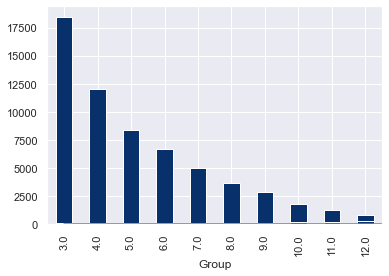

In [182]:
import numpy as np
import pandas as pd
import keras
from sklearn.cluster import KMeans

#display = display.drop(columns=['Гео'])
from sklearn.preprocessing import StandardScaler

id = display['Id']
categorical_cols = display.columns[128:].to_list()
data_numerical = display.drop(categorical_cols, axis=1)
data_numerical = data_numerical.drop(columns=['Id'], axis=1)
data_categorical = display[categorical_cols]

scaler = StandardScaler()
scaler.fit(data_numerical)
data_numerical = pd.DataFrame(scaler.transform(data_numerical),
 index=data_numerical.index,
 columns=data_numerical.columns)


data_preprocessed = data_numerical

def get_corr_cols(data, treshold):
 corr_matrix = data.corr().abs()
 upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
 to_drop = [column for column in upper.columns if any(upper[column] > treshold)]
 return to_drop

def trimm_correlated(df_in, threshold):
 df_corr = df_in.corr(method='pearson', min_periods=1)
 df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
 un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
 df_out = df_in[un_corr_idx]
 return df_out, list(set(range(189)) - set(un_corr_idx))

data_drop_corr, exclude = trimm_correlated(pd.DataFrame(data=data_preprocessed), 0.6)
exclude.sort()

excluded = set(data_preprocessed.columns.to_list()) - set(data_drop_corr.columns.to_list())

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

X = PCA(n_components=50).fit_transform(data_drop_corr.values)

clusterer_5 = KMeans(n_clusters=5, random_state=11, n_jobs=-1)
clusterer_5.fit(X)
labels_5 = clusterer_5.predict(X)

display['Кластер'] = labels_5 + 1
display

import numpy as np
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

pca = PCA(n_components=2)
pca.fit(data_drop_corr)
X_pca_2 = pca.transform(data_drop_corr)
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

from sklearn.cluster import DBSCAN

months1 = pd.read_csv("months1.csv", sep=';', encoding='cp1251') 
months2 = pd.read_csv("months2.csv", sep=';', encoding='cp1251') 
df = months1.append(months2)
df = df.reset_index()

delivery_cheque = df[df.Номенклатура == 'Доставка'].НомерЗаказаНаСайте.to_list()
delivery_cheque = pd.DataFrame(data=delivery_cheque)
delivery_cheque[1] = 1
delivery_cheque
df = df.merge(delivery_cheque, left_on = 'НомерЗаказаНаСайте', right_on = 0, how = 'left')
df = df.drop(columns=[0])
df = df.rename(columns={1:'Доставка'})
df = df.fillna(0)

df['Маржа'] = df['Маржа'].astype(str)
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(',', '.'))
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(' ', ''))
df['Маржа'] = df['Маржа'].astype(float)

df['Цена'] = df['Цена'].astype(str)
df['Цена'] = df['Цена'].apply(lambda x: x.replace(',', '.'))
df['Цена'] = df['Цена'].apply(lambda x: x.replace(' ', ''))
df['Цена'] = df['Цена'].astype(float)

df = df.drop(df[df.Телефон_new == '0'].index)
df = df.drop(df[df.ПричинаОтмены == '1.4 Ошибка выбора, будет новый заказ'].index)
df = df.drop(df[df.ПричинаОтмены == '1.1 Тест, контрольная закупка'].index)
df = df.drop(df[df.Маржа == 0].index)
df = df.drop(df[df.СуммаДокумента == 0].index)
df = df.drop(df[df.Количество == 0].index)
df = df.drop(df[df.НовыйСтатус  == 'Отменен'].index)
df = df.drop(df[df.НовыйСтатус  == 'Отменяется'].index)
df = df.drop(df[df.НовыйСтатус  == 'Расформирован ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'Принят в ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'В резерве'].index)
df = df.drop(df[df.НовыйСтатус  == 'Частичный возврат'].index)
df = df.drop(df[df.НовыйСтатус  == 'Скомплектован Регион'].index)
df = df.drop(df[df.НовыйСтатус  == 'Возврат'].index)
df = df.drop(df[df.НовыйСтатус  == 'Отправлен в ПВЗ'].index)
df = df.drop(df[df.НовыйСтатус  == 'Комплектация Регион'].index)
df = df.drop(df[df.НовыйСтатус  == 'Передан в Регион'].index)
df = df[df['Маржа'].notna()]
df = df[df['Группа2'].notna()]
df = df[df['Группа3'].notna()]
df = df[df['Группа4'].notna()]
df = df[df['Регион'].notna()]
df = df[df['Цена'].notna()]
df = df[df['СуммаСтроки'].notna()]
df = df[df['ЦенаЗакупки'].notna()]
df = df.drop(df[df.Маржа < -1000].index)
df = df.drop(df[df.Маржа > 10000].index)
df = df.drop(df[df.Цена < 10].index)
df = df.drop(df[df.Количество > 20].index)
df = df.drop_duplicates()

df['СуммаСтроки'] = df['СуммаСтроки'].astype(str)
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(',', '.'))
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(' ', ''))
df['СуммаСтроки'] = df['СуммаСтроки'].astype(float)

df['Дата'] = pd.to_datetime(df['Дата']).dt.date

df = df[df['Телефон_new'].isin(display['Id'].values)]

df = df.merge(display[['Id', 'Кластер']], left_on = 'Телефон_new', right_on = 'Id', how = 'left')

rfm = pd.DataFrame()
max = df['Дата'].max()
rfm[['id', 'кластер']] = display[['Id', 'Кластер']]
rfm['frequency'] = df[['Телефон_new', 'НомерЗаказаНаСайте']].groupby('Телефон_new').count().reset_index()['НомерЗаказаНаСайте']
rfm['recency'] = (max - df[['Телефон_new', 'Дата']].groupby('Телефон_new').max().reset_index()['Дата']).apply(lambda x: x.days)
rfm['monetary value'] = df[['Телефон_new', 'СуммаСтроки']].groupby('Телефон_new').sum().reset_index()['СуммаСтроки']
rfm = rfm.set_index('id')
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

rfmSeg = pd.DataFrame()
for i in range(0, 6):
    rfmSegmentation = rfm.loc[rfm['кластер'] == i].copy()
    rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
    rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
    rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary value'].apply(FMClass, args=('monetary value',quantiles,))
    rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)
    rfmSeg = rfmSeg.append(rfmSegmentation)

rfmSeg['Group'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

display = display.merge(rfmSeg, left_on='Id', right_index=True, how = 'left')
df.to_csv('clusters.csv', sep=';', encoding='utf-8')
display.to_csv('display.csv', sep=';', encoding='utf-8')

In [183]:
display

,Id,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,КоличествоЧековВыкупленные,СреднийЧекВыкупленные,СреднееЧислоТоваровЧекаВыкупленные,ВыручкаВыкупленная,КоличествоТоваровВыкупленные,СредняяМаржаВыкупленная,ДоляСамовывоза,ДоляВыкупленных,ОДЕЖДА,ППКП,КГТ,ИНОЕ,"ТЕКСТИЛЬ, ТРИКОТАЖ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",ОБУВЬ,ИГРУШКИ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,ДЕТСКОЕ ПИТАНИЕ,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ЖЕНСКИЕ ШТУЧКИ,ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,СОПУТСТВУЮЩИЕ ТОВАРЫ,ДЕТСКИЕ КОЛГОТКИ И НОСКИ,СРЕДСТВА ГИГИЕНЫ,ИЗДЕЛИЯ ИЗ ПЛАСТМАССЫ,ДЕТСКОЕ БЕЛЬЁ,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ВЕРХНЯЯ ДЕТСКАЯ ОДЕЖДА,КАНЦТОВАРЫ,ПОДГУЗНИКИ,ОБУВЬ ДЕТСКАЯ,ДЕТСКАЯ ОДЕЖДА (2-6 лет),СОПУТСТВУЮЩИЕ ТОВАРЫ ДЛЯ ОБУВИ,СРЕДСТВА БЫТОВОЙ ХИМИИ,ДЕТСКАЯ КОСМЕТИКА,ДЕТСКАЯ ОДЕЖДА (7-16 лет),ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,КОЛЯСКИ,КОНСТРУКТОРЫ,СОСКИ/ПУСТЫШКИ,ЭЛЕКТРОПРИБОРЫ,ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРОЖДЕННЫМИ,ДЕТСКИЕ СТУЛЬЯ ДЛЯ КОРМЛЕНИЯ,БУТЫЛОЧКИ,ПОСТЕЛЬНОЕ БЕЛЬЕ,ТВОРЧЕСТВО,ВСЁ ДЛЯ ПРАЗДНИКА,АКТИВНЫЙ ОТДЫХ,"ГОЛОВНЫЕ УБОРЫ, ВАРЕЖКИ, ПЕРЧАТКИ",ТОВАРЫ ДЛЯ МАМ,ПОЛИГРАФИЧЕСКАЯ ПРОДУКЦИЯ,ПЮРЕ,КАШИ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,ТОВАРЫ ДЛЯ КОШЕК,ЗАМЕНИТЕЛИ МОЛОКА,ПЕЛЕНКИ ОДНОРАЗОВЫЕ,НАСТОЛЬНЫЕ ИГРЫ,АКСЕССУАРЫ,"ФИГУРЫ, ПЕРСОНАЖИ",АВТОКРЕСЛА,ВЕЛОСИПЕДЫ/САМОКАТЫ,СПОРТИВНЫЕ КОМПЛЕКСЫ И ПЕСОЧНИЦЫ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",ПОСУДА,БАКАЛЕЯ,КОЛЯСКИ ДЛЯ КУКОЛ,"КОРЗИНЫ, ЯЩИКИ ДЛЯ ИГРУШЕК",АКСЕССУАРЫ ДЛЯ ВОЛОС,НАПИТКИ,МЯГКИЕ ИГРУШКИ,КАТАЛКИ/КАЧАЛКИ,КОНДИТЕРСКИЕ ИЗДЕЛИЯ,КОСМЕТИКА/ГИГИЕНА ДЛЯ МАМ,ТРУСИКИ НЕПРОМОКАЕМЫЕ,МОЛОКООТСОСЫ,ПРОДУКТЫ ПИТАНИЯ ДЛЯ МАМ,ХОДУНКИ/ПРЫГУНКИ,ЭЛЕКТРОМОБИЛИ/МАШИНЫ ПЕДАЛЬНЫЕ,МАНЕЖИ/ШЕЗЛОНГИ,МУЗЫКАЛЬНЫЕ ИНСТРУМЕНТЫ,ТЕХНИКА ДЛЯ КУХНИ,ДЕКОР,ТОВАРЫ ДЛЯ СОБАК,ФОТОАЛЬБОМЫ/ФОТОРАМКИ,АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР","КОПИЛКИ, БРЕЛОКИ, МАГНИТИКИ","ОДЕЖДА, ОБУВЬ",САНКИ/СНЕГОКАТЫ,ЭЛЕМЕНТЫ ПИТАНИЯ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ ПТИЦ,СИСТЕМЫ ХРАНЕНИЯ,ТОВАРЫ ДЛЯ ГРЫЗУНОВ,ТОВАРЫ ДЛЯ РЫБ,ОБУВЬ ЖЕНСКАЯ,КИСЛОМОЛОЧНЫЕ ПРОДУКТЫ,ЛАМПЫ/СВЕТИЛЬНИКИ,СУМКИ,ХОЗЯЙСТВЕННЫЕ ТОВАРЫ,СПОРТ.ИНВЕНТАРЬ,СУМКИ ДЛЯ МАМ,ГАЛАНТЕРЕЯ,СУВЕНИРНАЯ ПРОДУКЦИЯ,ТЕХНИКА ДЛЯ КРАСОТЫ И ЗДОРОВЬЯ,МЕДИАПРОДУКЦИЯ,ВИТАМИНЫ/БАДЫ,ЧАСЫ/ОЧКИ,"ШАПКИ, ШАРФЫ",БИЖУТЕРИЯ,СВЕТООТРАЖАЮЩИЕ ЭЛЕМЕНТЫ,ВЕТАПТЕКА,ТОВАРЫ ДЛЯ ХОРЬКОВ,ТОВАРЫ ДЛЯ ЧЕРЕПАХ И РЕПТИЛИЙ,ЗЕРКАЛА,"ГЛАДИЛЬНЫЕ ДОСКИ,СУШИЛКИ",ТЕХНИКА ДЛЯ ДОМА,Гео,Алтайский край,Амурская область,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Вологодская область,Воронежская область,Еврейская авт.область,Забайкальский край,Ивановская область,Иркутская область,Кабардино-Балкарская республика,Калининградская область,Калужская область,Камчатский край,Карачаево-Черкесская Республика,Кемеровская область,Кировская область,Костромская область,Краснодарский край,Красноярский край,Курская область,Ленинградская область,Липецкая область,Магаданская область,Москва,Московская область,Мурманская область,Нижегородская область,Новгородская область,Новосибирская область,Омская область,Оренбургская область,Пензенская область,Пермский край,Приморский край,Псковская область,Республика Адыгея,Республика Алтай,Республика Башкортостан,Республика Бурятия,Республика Дагестан,Республика Калмыкия,Республика Карелия,Республика Коми,Республика Марий Эл,Республика Мордовия,Республика Саха (Якутия),Республика Северная Осетия - Алания,Республика Татарстан,Республика Хакасия,Ростовская область,Рязанская область,Самарская область,Санкт-Петербург,Саратовская область,Сахалинская область,Свердловская область,Смоленская область,Ставропольский край,Тамбовская область,Тверская область,Томская область,Тульская область,Тюменская область,Удмуртская республика,Ульяновская область,Хабаровский край,Ханты-Мансийский автономный округ — Югра,Челябинская область,Чеченская республика,Чувашская Республика,Ямало-Ненецкий автономный округ,Ярославская область,Кластер,кластер,frequency,recency,monetary value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Group
0,55574948-524950

In [184]:
import numpy as np
import pandas as pd
import keras

df['СуммаСтроки'] = df['СуммаСтроки'].astype(str)
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(',', '.'))
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(' ', ''))
df['СуммаСтроки'] = df['СуммаСтроки'].astype(float)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(str)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(',', '.'))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(' ', ''))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(float)

group2 = df.groupby(['Телефон_new', 'Группа2']).sum()
group3 = df.groupby(['Телефон_new', 'Группа3']).sum()
group4 = df.groupby(['Телефон_new', 'Группа4']).sum()
type = df.groupby(['Телефон_new', 'Тип']).sum()

mba_clients = pd.DataFrame()
mba_clients['Id'] = df.drop_duplicates(subset='Телефон_new')['Телефон_new']
mba_clients = mba_clients.reset_index(drop=True)

#mba_clients_1 = pd.DataFrame()
#mba_clients_1['Id'] = df.drop_duplicates(subset='Телефон_new')['Телефон_new']
#mba_clients_1 = mba_clients.reset_index(drop=True)

for i in df.Тип.unique():
    mba_clients[i] = i
    mba_clients = mba_clients.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Тип'], how='left')
    mba_clients = mba_clients.drop(columns=[i])
    mba_clients = mba_clients.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_clients = mba_clients.fillna(0)

for i in df.Группа2.unique():
    mba_clients[i] = i
    mba_clients = mba_clients.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа2'], how='left')
    mba_clients = mba_clients.drop(columns=[i])
    mba_clients = mba_clients.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_clients = mba_clients.fillna(0)

for i in df.Группа3.unique():
    mba_clients[i] = i
    mba_clients = mba_clients.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа3'], how='left')
    mba_clients = mba_clients.drop(columns=[i])
    mba_clients = mba_clients.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_clients = mba_clients.fillna(0)

mba_clients = mba_clients.set_index('Id')

group2 = df.groupby(['НомерЗаказаНаСайте', 'Группа2']).sum()
group3 = df.groupby(['НомерЗаказаНаСайте', 'Группа3']).sum()
group4 = df.groupby(['НомерЗаказаНаСайте', 'Группа4']).sum()
type = df.groupby(['НомерЗаказаНаСайте', 'Тип']).sum()

mba_cheque = pd.DataFrame()
mba_cheque['Id'] = df.drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
mba_cheque = mba_cheque.reset_index(drop=True)

df.Тип.unique()

for i in df.Тип.unique():
    mba_cheque[i] = i
    mba_cheque = mba_cheque.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
    mba_cheque = mba_cheque.drop(columns=[i])
    mba_cheque = mba_cheque.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_cheque = mba_cheque.fillna(0)

for i in df.Группа2.unique():
    mba_cheque[i] = i
    mba_cheque = mba_cheque.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
    mba_cheque = mba_cheque.drop(columns=[i])
    mba_cheque = mba_cheque.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_cheque = mba_cheque.fillna(0)

for i in df.Группа3.unique():
    mba_cheque[i] = i
    mba_cheque = mba_cheque.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
    mba_cheque = mba_cheque.drop(columns=[i])
    mba_cheque = mba_cheque.rename(columns={'КоличествоПроданоКлиенту':i})
    mba_cheque = mba_cheque.fillna(0)

mba_cheque = mba_cheque.set_index('Id')

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_clients = mba_clients.applymap(encode_units)
basket_cheque = mba_cheque.applymap(encode_units)

frequent_items_clients = apriori(basket_clients, min_support=0.06, use_colnames=True)
frequent_items_cheque = apriori(basket_cheque, min_support=0.06, use_colnames=True)

basket_clients.to_csv('basket.csv', sep = ';', encoding = 'utf-8')

df['Процент'] = ((df['СуммаСтроки'] - df['ЦенаЗакупки']*df['Количество']) / df['СуммаСтроки'])*100

marga_type = df[['Тип', 'Процент']].groupby('Тип').mean()
marga_type = marga_type.rename(columns={'Процент':'Типм'})
marga_g2 = df[['Группа2', 'Процент']].groupby('Группа2').mean()
marga_g2 = marga_g2.rename(columns={'Процент':'Группа2м'})
marga_g3 = df[['Группа3', 'Процент']].groupby('Группа3').mean()
marga_g3 = marga_g3.rename(columns={'Процент':'Группа3м'})
marga_g4 = df[['Группа4', 'Процент']].groupby('Группа4').mean()
marga_g4 = marga_g4.rename(columns={'Процент':'Группа4м'})


rules_clients = association_rules(frequent_items_clients, metric="lift", min_threshold=1)
rules_cheque = association_rules(frequent_items_cheque, metric="lift", min_threshold=1)

rules_clients.loc[rules_clients['conviction'] != np.inf]

rules_cheque.loc[rules_cheque['conviction'] != np.inf]

group2 = df.groupby(['НомерЗаказаНаСайте', 'Группа2']).sum()
group3 = df.groupby(['НомерЗаказаНаСайте', 'Группа3']).sum()
type = df.groupby(['НомерЗаказаНаСайте', 'Тип']).sum()

dict_groups = df[['Тип', 'Группа2']].drop_duplicates('Группа2').set_index('Группа2').append(
df[['Тип', 'Группа3']].drop_duplicates('Группа3').set_index('Группа3'))

rules_1 = pd.DataFrame()
for j in range(0, 3):
    mba_type = pd.DataFrame()
    mba_type['Id'] = df.loc[df['Кластер'] == 2].drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
    mba_type = mba_type.reset_index(drop=True)
    if (j == 0):
        for i in df.Тип.unique():
            mba_type[i] = i
            mba_type = mba_type.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
            mba_type = mba_type.drop(columns=[i])
            mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
            mba_type = mba_type.fillna(0)
    else:
        if (j == 1):
            for i in df.Группа2.unique():
                mba_type[i] = i
                mba_type = mba_type.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
                mba_type = mba_type.drop(columns=[i])
                mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                mba_type = mba_type.fillna(0)
        else:
            if (j == 2):
                for i in df.Группа3.unique():
                    mba_type[i] = i
                    mba_type = mba_type.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
                    mba_type = mba_type.drop(columns=[i])
                    mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                    mba_type = mba_type.fillna(0)
    
    mba_type = mba_type.set_index('Id')
    basket_type = mba_type.applymap(encode_units)
    frequent_items_type = apriori(basket_type, min_support=0.01, use_colnames=True)
    rules_type = association_rules(frequent_items_type, metric="lift", min_threshold=0.5).sort_values(by=['lift', 'confidence'], ascending = [False, False])
    if rules_1.empty:
        rules_1 = rules_type.copy()
    else:
        rules_1 = rules_1.append(rules_type)
rules_1["antecedents"] = rules_1["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_1["consequents"] = rules_1["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_1 = rules_1.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])
rules_1['expected confidence'] = rules_1['confidence'] / rules_1['lift']
rules_1 = rules_1.merge(df.groupby('Тип').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_1 = rules_1.merge(df.groupby('Группа2').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_1 = rules_1.merge(df.groupby('Группа3').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_1['маржа абсолютная'] = rules_1[['Маржа_x', 'Маржа_y', 'Маржа']].min(axis=1)
rules_1['средняя стоимость'] = rules_1[['СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки']].min(axis=1)
rules_1 = rules_1.drop(columns=['Маржа_x', 'Маржа_y', 'СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки', 'Маржа'])
rules_1['маржа'] = rules_1['маржа абсолютная']/rules_1['средняя стоимость']
rules_1 = rules_1.merge(dict_groups, left_on='consequents', right_index = True, how = 'left')
rules_1

rules_2 = pd.DataFrame()
for j in range(0, 3):
    mba_type = pd.DataFrame()
    mba_type['Id'] = df.loc[df['Кластер'] == 5].drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
    mba_type = mba_type.reset_index(drop=True)
    if (j == 0):
        for i in df.Тип.unique():
            mba_type[i] = i
            mba_type = mba_type.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
            mba_type = mba_type.drop(columns=[i])
            mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
            mba_type = mba_type.fillna(0)
    else:
        if (j == 1):
            for i in df.Группа2.unique():
                mba_type[i] = i
                mba_type = mba_type.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
                mba_type = mba_type.drop(columns=[i])
                mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                mba_type = mba_type.fillna(0)
        else:
            if (j == 2):
                for i in df.Группа3.unique():
                    mba_type[i] = i
                    mba_type = mba_type.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
                    mba_type = mba_type.drop(columns=[i])
                    mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                    mba_type = mba_type.fillna(0)
    
    mba_type = mba_type.set_index('Id')
    basket_type = mba_type.applymap(encode_units)
    frequent_items_type = apriori(basket_type, min_support=0.003, use_colnames=True)
    rules_type = association_rules(frequent_items_type, metric="lift", min_threshold=0.05).sort_values(by=['lift', 'confidence'], ascending = [False, False])
    if rules_2.empty:
        rules_2 = rules_type.copy()
    else:
        rules_2 = rules_2.append(rules_type)
rules_2["antecedents"] = rules_2["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_2["consequents"] = rules_2["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_2 = rules_2.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])
rules_2['expected confidence'] = rules_2['confidence'] / rules_2['lift']
rules_2 = rules_2.merge(df.groupby('Тип').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_2 = rules_2.merge(df.groupby('Группа2').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_2 = rules_2.merge(df.groupby('Группа3').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_2['маржа абсолютная'] = rules_2[['Маржа_x', 'Маржа_y', 'Маржа']].min(axis=1)
rules_2['средняя стоимость'] = rules_2[['СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки']].min(axis=1)
rules_2 = rules_2.drop(columns=['Маржа_x', 'Маржа_y', 'СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки', 'Маржа'])
rules_2['маржа'] = rules_2['маржа абсолютная']/rules_2['средняя стоимость']
rules_2 = rules_2.merge(dict_groups, left_on='consequents', right_index = True, how = 'left')
rules_2

rules_3 = pd.DataFrame()
for j in range(0, 3):
    mba_type = pd.DataFrame()
    mba_type['Id'] = df.loc[df['Кластер'] == 4].drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
    mba_type = mba_type.reset_index(drop=True)
    if (j == 0):
        for i in df.Тип.unique():
            mba_type[i] = i
            mba_type = mba_type.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
            mba_type = mba_type.drop(columns=[i])
            mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
            mba_type = mba_type.fillna(0)
    else:
        if (j == 1):
            for i in df.Группа2.unique():
                mba_type[i] = i
                mba_type = mba_type.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
                mba_type = mba_type.drop(columns=[i])
                mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                mba_type = mba_type.fillna(0)
        else:
            if (j == 2):
                for i in df.Группа3.unique():
                    mba_type[i] = i
                    mba_type = mba_type.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
                    mba_type = mba_type.drop(columns=[i])
                    mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                    mba_type = mba_type.fillna(0)
                
    mba_type = mba_type.set_index('Id')
    basket_type = mba_type.applymap(encode_units)
    frequent_items_type = apriori(basket_type, min_support=0.01, use_colnames=True)
    data = association_rules(frequent_items_type, metric="lift", min_threshold=0.8)
    rules_type = data.sort_values(by=['lift', 'confidence'], ascending = [False, False]).head(int(4*len(data)/5))
    if rules_3.empty:
        rules_3 = rules_type.copy()
    else:
        rules_3 = rules_3.append(rules_type)
rules_3["antecedents"] = rules_3["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_3["consequents"] = rules_3["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_3 = rules_3.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])
rules_3['expected confidence'] = rules_3['confidence'] / rules_3['lift']
rules_3 = rules_3.merge(df.groupby('Тип').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_3 = rules_3.merge(df.groupby('Группа2').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_3 = rules_3.merge(df.groupby('Группа3').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_3['маржа абсолютная'] = rules_3[['Маржа_x', 'Маржа_y', 'Маржа']].min(axis=1)
rules_3['средняя стоимость'] = rules_3[['СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки']].min(axis=1)
rules_3 = rules_3.drop(columns=['Маржа_x', 'Маржа_y', 'СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки', 'Маржа'])
rules_3['маржа'] = rules_3['маржа абсолютная']/rules_3['средняя стоимость']
rules_3 = rules_3.merge(dict_groups, left_on='consequents', right_index = True, how = 'left')
rules_3

rules_4 = pd.DataFrame()
for j in range(0, 3):
    mba_type = pd.DataFrame()
    mba_type['Id'] = df.loc[df['Кластер'] == 1].drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
    mba_type = mba_type.reset_index(drop=True)
    if (j == 0):
        for i in df.Тип.unique():
            mba_type[i] = i
            mba_type = mba_type.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
            mba_type = mba_type.drop(columns=[i])
            mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
            mba_type = mba_type.fillna(0)
    else:
        if (j == 1):
            for i in df.Группа2.unique():
                mba_type[i] = i
                mba_type = mba_type.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
                mba_type = mba_type.drop(columns=[i])
                mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                mba_type = mba_type.fillna(0)
        else:
            if (j == 2):
                for i in df.Группа3.unique():
                    mba_type[i] = i
                    mba_type = mba_type.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
                    mba_type = mba_type.drop(columns=[i])
                    mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                    mba_type = mba_type.fillna(0)

    mba_type = mba_type.set_index('Id')
    basket_type = mba_type.applymap(encode_units)
    frequent_items_type  = apriori(basket_type, min_support=0.05, use_colnames=True)
    data = association_rules(frequent_items_type, metric="lift", min_threshold=0.8)
    rules_type = data.sort_values(by=['lift', 'confidence'], ascending = [False, False])
    if rules_4.empty:
        rules_4 = rules_type.copy()
    else:
        rules_4 = rules_4.append(rules_type)
rules_4["antecedents"] = rules_4["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_4["consequents"] = rules_4["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_4 = rules_4.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])
rules_4['expected confidence'] = rules_4['confidence'] / rules_4['lift']
rules_4 = rules_4.merge(df.groupby('Тип').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_4 = rules_4.merge(df.groupby('Группа2').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_4 = rules_4.merge(df.groupby('Группа3').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_4['маржа абсолютная'] = rules_4[['Маржа_x', 'Маржа_y', 'Маржа']].min(axis=1)
rules_4['средняя стоимость'] = rules_4[['СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки']].min(axis=1)
rules_4 = rules_4.drop(columns=['Маржа_x', 'Маржа_y', 'СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки', 'Маржа'])
rules_4['маржа'] = rules_4['маржа абсолютная']/rules_4['средняя стоимость']
rules_4 = rules_4.merge(dict_groups, left_on='consequents', right_index = True, how = 'left')
rules_4

rules_5 = pd.DataFrame()
for j in range(0, 3):
    mba_type = pd.DataFrame()
    mba_type['Id'] = df.loc[df['Кластер'] == 3].drop_duplicates(subset='НомерЗаказаНаСайте')['НомерЗаказаНаСайте']
    mba_type = mba_type.reset_index(drop=True)
    if (j == 0):
        for i in df.Тип.unique():
            mba_type[i] = i
            mba_type = mba_type.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Тип'], how='left')
            mba_type = mba_type.drop(columns=[i])
            mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
            mba_type = mba_type.fillna(0)
    else:
        if (j == 1):
            for i in df.Группа2.unique():
                mba_type[i] = i
                mba_type = mba_type.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа2'], how='left')
                mba_type = mba_type.drop(columns=[i])
                mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                mba_type = mba_type.fillna(0)
        else:
            if (j == 2):
                for i in df.Группа3.unique():
                    mba_type[i] = i
                    mba_type = mba_type.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['НомерЗаказаНаСайте', 'Группа3'], how='left')
                    mba_type = mba_type.drop(columns=[i])
                    mba_type = mba_type.rename(columns={'КоличествоПроданоКлиенту':i})
                    mba_type = mba_type.fillna(0)
    
    mba_type = mba_type.set_index('Id')
    basket_type = mba_type.applymap(encode_units)
    frequent_items_type = apriori(basket_type, min_support=0.01, use_colnames=True)
    rules_type = association_rules(frequent_items_type, metric="lift", min_threshold=0.5).sort_values(by=['lift', 'confidence'], ascending = [False, False])
    if rules_5.empty:
        rules_5 = rules_type.copy()
    else:
        rules_5 = rules_5.append(rules_type)
rules_5["antecedents"] = rules_5["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_5["consequents"] = rules_5["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
rules_5 = rules_5.drop(columns=['antecedent support', 'consequent support', 'conviction', 'leverage'])
rules_5['expected confidence'] = rules_5['confidence'] / rules_5['lift']
rules_5 = rules_5.merge(df.groupby('Тип').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_5 = rules_5.merge(df.groupby('Группа2').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_5 = rules_5.merge(df.groupby('Группа3').mean()[['СуммаСтроки', 'Маржа']], left_on=['consequents'], right_index=True, how='left')
rules_5['маржа абсолютная'] = rules_5[['Маржа_x', 'Маржа_y', 'Маржа']].min(axis=1)
rules_5['средняя стоимость'] = rules_5[['СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки']].min(axis=1)
rules_5 = rules_5.drop(columns=['Маржа_x', 'Маржа_y', 'СуммаСтроки_x', 'СуммаСтроки_y', 'СуммаСтроки', 'Маржа'])
rules_5['маржа'] = rules_5['маржа абсолютная']/rules_5['средняя стоимость']
rules_5 = rules_5.merge(dict_groups, left_on='consequents', right_index = True, how = 'left')
rules_5

df.groupby('Группа2').mean()

rules_1.to_csv('rules_1.csv', sep = ';', encoding = 'cp1251')
rules_2.to_csv('rules_2.csv', sep = ';', encoding = 'cp1251')
rules_3.to_csv('rules_3.csv', sep = ';', encoding = 'cp1251')
rules_4.to_csv('rules_4.csv', sep = ';', encoding = 'cp1251')
rules_5.to_csv('rules_5.csv', sep = ';', encoding = 'cp1251')



In [185]:
df = pd.read_csv("clusters.csv", sep=';', encoding='utf-8').drop(columns = ['Unnamed: 0', 'index', 'Кластер'])
df['Маржа'] = df['Маржа'].astype(str)
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(',', '.'))
df['Маржа'] = df['Маржа'].apply(lambda x: x.replace(' ', ''))
df['Маржа'] = df['Маржа'].astype(float)
df['СуммаСтроки'] = df['СуммаСтроки'].astype(str)
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(',', '.'))
df['СуммаСтроки'] = df['СуммаСтроки'].apply(lambda x: x.replace(' ', ''))
df['СуммаСтроки'] = df['СуммаСтроки'].astype(float)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(str)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(',', '.'))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(' ', ''))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(float)
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].astype(str)
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].apply(lambda x: x.replace(',', '.'))
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].apply(lambda x: x.replace(' ', ''))
df['СуммаЗаказаНаСайте'] = df['СуммаЗаказаНаСайте'].astype(float)
df['Цена'] = df['Цена'].astype(str)
df['Цена'] = df['Цена'].apply(lambda x: x.replace(',', '.'))
df['Цена'] = df['Цена'].apply(lambda x: x.replace(' ', ''))
df['Цена'] = df['Цена'].astype(float)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(str)
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(',', '.'))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].apply(lambda x: x.replace(' ', ''))
df['ЦенаЗакупки'] = df['ЦенаЗакупки'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (29,30,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [201]:
df.Дата = pd.to_datetime(df.Дата)
df_last = df.loc[df.Дата.dt.month == 10]
df_first = df.loc[df.Дата.dt.month != 10]
display = pd.DataFrame()
display['Id'] = df_first.drop_duplicates(subset='Телефон_new')['Телефон_new']
display = display.reset_index(drop=True)
df_first['МаржаПолная'] = df_first['Маржа'] * df_first['Количество']
mean_non_dupe = df_first.drop_duplicates(subset='НомерЗаказаНаСайте').groupby('Телефон_new').mean()
unique = df_first.groupby('Телефон_new').nunique()
mean =  df_first.groupby('Телефон_new').mean()
sum = df_first.groupby('Телефон_new').sum()
non_dupe = df_first.drop_duplicates(subset='НомерЗаказаНаСайте')
df_bought = df_first[df_first.КоличествоПроданоКлиенту != 0]
df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']
df_bought['МаржаПолнаяВыкупленная'] = df_bought['Маржа'] * df_bought['КоличествоПроданоКлиенту']
mean_non_dupe_bought = df_bought.groupby(['Телефон_new', 'НомерЗаказаНаСайте']).sum()['Итог'].groupby('Телефон_new').mean()
unique_bought = df_bought.groupby('Телефон_new').nunique()
mean_bought =  df_bought.groupby('Телефон_new').mean()
sum_bought = df_bought.groupby('Телефон_new').sum()
group2 = df_bought.groupby(['Телефон_new', 'Группа2']).sum()
group3 = df_bought.groupby(['Телефон_new', 'Группа3']).sum()
type = df_bought.groupby(['Телефон_new', 'Тип']).sum()
self_carry =  df_bought[(df_bought['МетодДоставки'] == 'Самовывоз') | (df_bought['МетодДоставки'] == 'Pick point')].groupby('Телефон_new').sum()['КоличествоПроданоКлиенту'] / df_bought.groupby('Телефон_new').sum()['КоличествоПроданоКлиенту']
display = display.merge(unique['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧеков'})
display = display.merge(mean_non_dupe['СуммаЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаЗаказаНаСайте':'СреднийЧек'})
display = display.merge(mean['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'СреднееЧислоТоваровЧека'})
display = display.merge(sum['СуммаСтроки'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаСтроки':'Выручка'})
display = display.merge(sum['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'КоличествоТоваров'})
display = display.merge(mean['МаржаПолная'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'МаржаПолная':'СредняяМаржа'})
display = display.merge(unique_bought['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧековВыкупленные'})
display = display.fillna(0)
display = display.merge(mean_non_dupe_bought, left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'СреднийЧекВыкупленные'})
display = display.fillna(0)
display = display.merge(mean['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'СреднееЧислоТоваровЧекаВыкупленные'})
display = display.fillna(0)
display = display.merge(sum_bought['Итог'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'ВыручкаВыкупленная'})
display = display.fillna(0)
display = display.merge(sum['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'КоличествоТоваровВыкупленные'})
display = display.fillna(0)
display = display.merge(mean_bought['МаржаПолнаяВыкупленная'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'МаржаПолнаяВыкупленная':'СредняяМаржаВыкупленная'})
display = display.fillna(0)
display = display.merge(self_carry.to_frame().fillna(0), left_on='Id', right_index=True, how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'ДоляСамовывоза'})
display = display.fillna(0)
display = display[display.КоличествоТоваровВыкупленные != 0]
display['ДоляВыкупленных'] = display['КоличествоТоваровВыкупленные'] / display['КоличествоТоваров']
for i in df.Тип.unique():
    display[i] = i
    display = display.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Тип'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']
for i in df.Группа2.unique():
    display[i] = i
    display = display.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа2'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']
for i in df.Группа3.unique():
    display[i] = i
    display = display.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа3'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']

<ipython-input-201-80220f2e8570>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first['МаржаПолная'] = df_first['Маржа'] * df_first['Количество']
<ipython-input-201-80220f2e8570>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']
<ipython-input-201-80220f2e8570>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [202]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df_last['Цель'] = 1
display = display.merge(df_last[['Телефон_new', 'Цель']], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.drop(columns=['Телефон_new'])
display = display.fillna(0)
display = display.drop_duplicates('Id')
x = display.drop(columns = ['Id', 'Цель']).values
y = display.Цель
x = preprocessing.StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
best = {'colsample_bytree': 0.59, 'gamma': 0.09, 'learning_rate': 0.32, 'max_depth': 22, 'min_child_weight': 1.0, 'n_estimators': 9, 'subsample': 0.92}

<ipython-input-202-7e0a3ab145b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['Цель'] = 1


In [516]:

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import warnings

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(x_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 5)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:01:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:01:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/30 [00:07<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:01:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/30 [00:11<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:01:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/30 [00:16<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:01:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/30 [00:20<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:02:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/30 [00:24<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



CrossValMean:                                                                                                          
0.843437567605297                                                                                                      
  3%|█▌                                              | 1/30 [00:28<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:02:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                              | 1/30 [00:28<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:02:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                              | 1/30 [00:55<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:02:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                              | 1/30 [01:05<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:02:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                              | 1/30 [01:16<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  3%|█▌                                              | 1/30 [01:26<13:41, 28.32s/trial, best loss: 0.15656243239470302]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



CrossValMean:                                                                                                          
0.8521098405197092                                                                                                     
  7%|███▏                                            | 2/30 [01:37<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                            | 2/30 [01:40<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                            | 2/30 [01:43<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                            | 2/30 [01:46<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                            | 2/30 [01:49<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  7%|███▏                                            | 2/30 [01:52<24:21, 52.20s/trial, best loss: 0.14789015948029083]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



CrossValMean:                                                                                                          
0.8632039062767394                                                                                                     
[10:03:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [01:54<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [01:59<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [02:03<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [02:07<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [02:11<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 10%|████▊                                           | 3/30 [02:15<16:21, 36.37s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



CrossValMean:                                                                                                          
0.8534591445777784                                                                                                     
 13%|██████▍                                         | 4/30 [02:19<13:45, 31.74s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:03:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|██████▍                                         | 4/30 [02:19<13:45, 31.74s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|██████▍                                         | 4/30 [02:25<13:45, 31.74s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|██████▍                                         | 4/30 [02:28<13:45, 31.74s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 13%|██████▍                                         | 4/30 [02:31<13:45, 31.74s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CrossValMean:                                                                                                          
0.8594559233097515                                                                                                     
 17%|████████                                        | 5/30 [02:36<11:00, 26.40s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|████████                                        | 5/30 [02:47<11:00, 26.40s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|████████                                        | 5/30 [02:55<11:00, 26.40s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|████████                                        | 5/30 [03:04<11:00, 26.40s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:04:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 17%|████████                                        | 5/30 [03:13<11:00, 26.40s/trial, best loss: 0.13679609372326063]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:05:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CrossValMean:                                                                                                          
0.864714638143518                                                                                                      
 20%|██████████                                        | 6/30 [03:33<14:43, 36.82s/trial, best loss: 0.135285361856482]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:05:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:05:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|██████████                                        | 6/30 [03:48<14:43, 36.82s/trial, best loss: 0.135285361856482]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:05:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|██████████                                        | 6/30 [04:01<14:43, 36.82s/trial, best loss: 0.135285361856482]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:05:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 20%|██████████                                        | 6/30 [04:18<17:15, 43.14s/trial, best loss: 0.135285361856482]


KeyboardInterrupt: 

In [203]:
import xgboost
xgb = xgboost.XGBClassifier(**best)
xgb = xgb.fit(x_train,y_train)
y_class = xgb.predict_proba(x)
y_class = [row[1] for row in y_class]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [204]:
df.Дата = pd.to_datetime(df.Дата)
df_last = df.loc[df.Дата.dt.month == 10]
df_first = df.loc[df.Дата.dt.month != 10]
display = pd.DataFrame()
display['Id'] = df_first.drop_duplicates(subset='Телефон_new')['Телефон_new']
display = display.reset_index(drop=True)
df_first['МаржаПолная'] = df_first['Маржа'] * df_first['Количество']
mean_non_dupe = df_first.drop_duplicates(subset='НомерЗаказаНаСайте').groupby('Телефон_new').mean()
unique = df_first.groupby('Телефон_new').nunique()
mean =  df_first.groupby('Телефон_new').mean()
sum = df_first.groupby('Телефон_new').sum()
non_dupe = df_first.drop_duplicates(subset='НомерЗаказаНаСайте')
df_bought = df_first[df_first.КоличествоПроданоКлиенту != 0]
df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']
df_bought['МаржаПолнаяВыкупленная'] = df_bought['Маржа'] * df_bought['КоличествоПроданоКлиенту']
mean_non_dupe_bought = df_bought.groupby(['Телефон_new', 'НомерЗаказаНаСайте']).sum()['Итог'].groupby('Телефон_new').mean()
unique_bought = df_bought.groupby('Телефон_new').nunique()
mean_bought =  df_bought.groupby('Телефон_new').mean()
sum_bought = df_bought.groupby('Телефон_new').sum()
group2 = df_bought.groupby(['Телефон_new', 'Группа2']).sum()
group3 = df_bought.groupby(['Телефон_new', 'Группа3']).sum()
type = df_bought.groupby(['Телефон_new', 'Тип']).sum()
self_carry =  df_bought[(df_bought['МетодДоставки'] == 'Самовывоз') | (df_bought['МетодДоставки'] == 'Pick point')].groupby('Телефон_new').sum()['КоличествоПроданоКлиенту'] / df_bought.groupby('Телефон_new').sum()['КоличествоПроданоКлиенту']
display = display.merge(unique['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧеков'})
display = display.merge(mean_non_dupe['СуммаЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаЗаказаНаСайте':'СреднийЧек'})
display = display.merge(mean['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'СреднееЧислоТоваровЧека'})
display = display.merge(sum['СуммаСтроки'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'СуммаСтроки':'Выручка'})
display = display.merge(sum['Количество'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'Количество':'КоличествоТоваров'})
display = display.merge(mean['МаржаПолная'], left_on='Id', right_on='Телефон_new', how = 'inner')
display = display.rename(columns={'МаржаПолная':'СредняяМаржа'})
display = display.merge(unique_bought['НомерЗаказаНаСайте'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'НомерЗаказаНаСайте':'КоличествоЧековВыкупленные'})
display = display.fillna(0)
display = display.merge(mean_non_dupe_bought, left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'СреднийЧекВыкупленные'})
display = display.fillna(0)
display = display.merge(mean['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'СреднееЧислоТоваровЧекаВыкупленные'})
display = display.fillna(0)
display = display.merge(sum_bought['Итог'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'Итог':'ВыручкаВыкупленная'})
display = display.fillna(0)
display = display.merge(sum['КоличествоПроданоКлиенту'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'КоличествоТоваровВыкупленные'})
display = display.fillna(0)
display = display.merge(mean_bought['МаржаПолнаяВыкупленная'], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.rename(columns={'МаржаПолнаяВыкупленная':'СредняяМаржаВыкупленная'})
display = display.fillna(0)
display = display.merge(self_carry.to_frame().fillna(0), left_on='Id', right_index=True, how = 'left')
display = display.rename(columns={'КоличествоПроданоКлиенту':'ДоляСамовывоза'})
display = display.fillna(0)
display = display[display.КоличествоТоваровВыкупленные != 0]
display['ДоляВыкупленных'] = display['КоличествоТоваровВыкупленные'] / display['КоличествоТоваров']
for i in df.Тип.unique():
    display[i] = i
    display = display.merge(type['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Тип'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']
for i in df.Группа2.unique():
    display[i] = i
    display = display.merge(group2['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа2'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']
for i in df.Группа3.unique():
    display[i] = i
    display = display.merge(group3['КоличествоПроданоКлиенту'], left_on=['Id', i], right_on=['Телефон_new', 'Группа3'], how='left')
    display = display.drop(columns=[i])
    display = display.rename(columns={'КоличествоПроданоКлиенту':i})
    display = display.fillna(0)
    display[i] = display[i] / display['КоличествоТоваровВыкупленные']

<ipython-input-204-80220f2e8570>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first['МаржаПолная'] = df_first['Маржа'] * df_first['Количество']
<ipython-input-204-80220f2e8570>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bought['Итог'] = df_bought['Цена'] * df_bought['КоличествоПроданоКлиенту']
<ipython-input-204-80220f2e8570>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [205]:
from sklearn import preprocessing
df_last = df_last.merge(mean_non_dupe_bought, left_on='Id', right_on='Телефон_new', how = 'left')
df_last = df_last.rename(columns={'Итог':'СреднийЧекВыкупленные'})
df_last = df_last.fillna(0)
df_last['Цель'] = df_last['СреднийЧекВыкупленные']
display = display.merge(df_last[['Телефон_new', 'Цель']], left_on='Id', right_on='Телефон_new', how = 'left')
display = display.drop(columns=['Телефон_new'])
display = display.fillna(0)
display = display.drop_duplicates('Id')
x = display.drop(columns = ['Id', 'Цель']).values
y = display.Цель
x = preprocessing.StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
best = {'colsample_bytree': 0.12, 'gamma': 0.01, 'learning_rate': 0.09, 'max_depth': 23, 'min_child_weight': 2.0, 'subsample': 0.98}

In [ ]:

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import warnings

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = XGBRegressor(max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(x_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 3)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

In [206]:
xgr = xgboost.XGBRegressor(**best)
xgr = xgr.fit(x_train,y_train)
y_reg = xgr.predict(x)

In [207]:
display

,Id,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,КоличествоЧековВыкупленные,СреднийЧекВыкупленные,СреднееЧислоТоваровЧекаВыкупленные,ВыручкаВыкупленная,КоличествоТоваровВыкупленные,СредняяМаржаВыкупленная,ДоляСамовывоза,ДоляВыкупленных,ОДЕЖДА,ППКП,КГТ,ИНОЕ,"ТЕКСТИЛЬ, ТРИКОТАЖ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ИГРУШКИ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",ДЕТСКОЕ ПИТАНИЕ,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ЖЕНСКИЕ ШТУЧКИ,ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,СОПУТСТВУЮЩИЕ ТОВАРЫ,ДЕТСКИЕ КОЛГОТКИ И НОСКИ,СРЕДСТВА ГИГИЕНЫ,ИЗДЕЛИЯ ИЗ ПЛАСТМАССЫ,ДЕТСКОЕ БЕЛЬЁ,ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ВЕРХНЯЯ ДЕТСКАЯ ОДЕЖДА,ПОДГУЗНИКИ,ОБУВЬ ДЕТСКАЯ,ДЕТСКАЯ ОДЕЖДА (2-6 лет),СОПУТСТВУЮЩИЕ ТОВАРЫ ДЛЯ ОБУВИ,СРЕДСТВА БЫТОВОЙ ХИМИИ,ДЕТСКАЯ КОСМЕТИКА,ДЕТСКАЯ ОДЕЖДА (7-16 лет),ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,КОЛЯСКИ,КОНСТРУКТОРЫ,СОСКИ/ПУСТЫШКИ,ЭЛЕКТРОПРИБОРЫ,ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРОЖДЕННЫМИ,ДЕТСКИЕ СТУЛЬЯ ДЛЯ КОРМЛЕНИЯ,БУТЫЛОЧКИ,ПОСТЕЛЬНОЕ БЕЛЬЕ,КАНЦТОВАРЫ,ТВОРЧЕСТВО,ВСЁ ДЛЯ ПРАЗДНИКА,АКТИВНЫЙ ОТДЫХ,"ГОЛОВНЫЕ УБОРЫ, ВАРЕЖКИ, ПЕРЧАТКИ",ТОВАРЫ ДЛЯ МАМ,ПОЛИГРАФИЧЕСКАЯ ПРОДУКЦИЯ,ПЮРЕ,КАШИ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,ТОВАРЫ ДЛЯ КОШЕК,ЗАМЕНИТЕЛИ МОЛОКА,ПЕЛЕНКИ ОДНОРАЗОВЫЕ,НАСТОЛЬНЫЕ ИГРЫ,АКСЕССУАРЫ,"ФИГУРЫ, ПЕРСОНАЖИ",АВТОКРЕСЛА,ВЕЛОСИПЕДЫ/САМОКАТЫ,МУЗЫКАЛЬНЫЕ ИНСТРУМЕНТЫ,СПОРТИВНЫЕ КОМПЛЕКСЫ И ПЕСОЧНИЦЫ,ИГРУШКИ ДЛЯ МАЛЬЧИКОВ,"ДЕТСКАЯ МЕБЕЛЬ, МАТРАСЫ",ПОСУДА,БАКАЛЕЯ,КОЛЯСКИ ДЛЯ КУКОЛ,"КОРЗИНЫ, ЯЩИКИ ДЛЯ ИГРУШЕК",АКСЕССУАРЫ ДЛЯ ВОЛОС,НАПИТКИ,МЯГКИЕ ИГРУШКИ,КАТАЛКИ/КАЧАЛКИ,КОНДИТЕРСКИЕ ИЗДЕЛИЯ,КОСМЕТИКА/ГИГИЕНА ДЛЯ МАМ,ТРУСИКИ НЕПРОМОКАЕМЫЕ,МОЛОКООТСОСЫ,ПРОДУКТЫ ПИТАНИЯ ДЛЯ МАМ,ХОДУНКИ/ПРЫГУНКИ,МАНЕЖИ/ШЕЗЛОНГИ,ТЕХНИКА ДЛЯ КУХНИ,ДЕКОР,ЭЛЕКТРОМОБИЛИ/МАШИНЫ ПЕДАЛЬНЫЕ,ТОВАРЫ ДЛЯ СОБАК,ФОТОАЛЬБОМЫ/ФОТОРАМКИ,АКСЕССУАРЫ ДЛЯ ДЕВОЧЕК,"АКСЕССУАРЫ МАКИЯЖ, МАНИКЮР","КОПИЛКИ, БРЕЛОКИ, МАГНИТИКИ","ОДЕЖДА, ОБУВЬ",САНКИ/СНЕГОКАТЫ,ЭЛЕМЕНТЫ ПИТАНИЯ,БЫТОВАЯ ХИМИЯ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ ПТИЦ,СИСТЕМЫ ХРАНЕНИЯ,ТОВАРЫ ДЛЯ ГРЫЗУНОВ,ТОВАРЫ ДЛЯ РЫБ,ОБУВЬ ЖЕНСКАЯ,КИСЛОМОЛОЧНЫЕ ПРОДУКТЫ,ЛАМПЫ/СВЕТИЛЬНИКИ,"ШАПКИ, ШАРФЫ",СУМКИ,ХОЗЯЙСТВЕННЫЕ ТОВАРЫ,СПОРТ.ИНВЕНТАРЬ,СУМКИ ДЛЯ МАМ,ГАЛАНТЕРЕЯ,СУВЕНИРНАЯ ПРОДУКЦИЯ,МЕДИАПРОДУКЦИЯ,ТЕХНИКА ДЛЯ КРАСОТЫ И ЗДОРОВЬЯ,ЧАСЫ/ОЧКИ,БИЖУТЕРИЯ,СВЕТООТРАЖАЮЩИЕ ЭЛЕМЕНТЫ,ВЕТАПТЕКА,ВИТАМИНЫ/БАДЫ,ТОВАРЫ ДЛЯ ЧЕРЕПАХ И РЕПТИЛИЙ,ТОВАРЫ ДЛЯ ХОРЬКОВ,ЗЕРКАЛА,"ГЛАДИЛЬНЫЕ ДОСКИ,СУШИЛКИ",ТЕХНИКА ДЛЯ ДОМА,Цель
0,55574948-52495050484877,1,1634.00000,1.00000,1585.00000,13,38.24923,1.00000,1585.00000,1.00000,1585.00000,13,38.24923,0.00000,1.00000,0.84615,0.07692,0.07692,0.00000,0.84615,0.07692,0.07692,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.76923,0.07692,0.07692,0.07692,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,55575656-49565651494970,1,1915.00000,1.00000,1816.00000,11,-0.94182,1.00000,1816.00000,1.00000,1816.00000,11,-0.94182,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09091,0.90909,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.

In [208]:
rules = {'Cluster': [1, 2, 3, 4, 5],
        'Категория': ['КОСМЕТИКА/ГИГИЕНА', 'ОДЕЖДА', 'ТЕКСТИЛЬ, ТРИКОТАЖ', 'КОСМЕТИКА/ГИГИЕНА', 'ПОСТЕЛЬНОЕ БЕЛЬЕ'],
         'Маржа' : [38.63, 287.96, 281.70, 38.63, 261.15],
         'СредняяСтоимость' : [250.44, 917.66, 868.67, 250.44, 748.41],
         'МаржаПроцентная' : [0.15, 0.314, 0.324, 0.1542, 0.349]
        }
rules_df = pd.DataFrame(rules, columns = ['Cluster', 'Категория', 'Маржа', 'СредняяСтоимость', 'МаржаПроцентная']).set_index('Cluster')

In [209]:
del sum
display_c = pd.read_csv("display.csv", sep=';', encoding='utf-8')
display_clusters = display_c[['Id', 'Кластер', 'RFMClass']].set_index('Id')
res = pd.DataFrame(display['Id'])
res = res.merge(display_clusters, left_on = 'Id', right_index = True, how = 'left')
res['RFMClass'] = res['RFMClass'].apply(lambda x: sum(int(digit) for digit in str(x)))
res['proba'] = y_class
res['value'] = y_reg
res['expectancy'] = y_class * y_reg
res = res.reset_index().drop(columns = 'index')

In [210]:
res = res.merge(display_c.iloc[:, 1: 14].set_index('Id'), left_on = 'Id', right_index = True, how = 'left')

In [211]:
res = res.merge(rules_df, left_on = 'Кластер', right_index=True, how = 'left')

In [212]:
res_ratings = res[['Кластер', 'RFMClass', 'proba', 'value', 'expectancy', 'СреднийЧек', 'СреднееЧислоТоваровЧека']].merge(res.groupby('Кластер').mean()[['СреднийЧек', 'КоличествоТоваров']], left_on = 'Кластер', right_index = True, how = 'left')

In [213]:
res

,Id,Кластер,RFMClass,proba,value,expectancy,КоличествоЧеков,СреднийЧек,СреднееЧислоТоваровЧека,Выручка,КоличествоТоваров,СредняяМаржа,КоличествоЧековВыкупленные,СреднийЧекВыкупленные,СреднееЧислоТоваровЧекаВыкупленные,ВыручкаВыкупленная,КоличествоТоваровВыкупленные,СредняяМаржаВыкупленная,Категория,Маржа,СредняяСтоимость,МаржаПроцентная
0,55574948-52495050484877,2,8,0.11295,506.72809,57.23696,1,1634.00000,1.00000,1585.00000,13,38.24923,1.00000,1585.00000,1.00000,1585.00000,13,38.24923,ОДЕЖДА,287.96000,917.66000,0.31400
1,55575656-49565651494970,2,9,0.12209,76.75237,9.37037,1,1915.00000,1.00000,1816.00000,11,-0.94182,1.00000,1816.00000,1.00000,1816.00000,11,-0.94182,ОДЕЖДА,287.96000,917.66000,0.31400
2,55575155-54535648525672,3,9,0.09094,34.18322,3.10869,4,15147.00000,1.00000,85842.00000,11,2365.93909,3.00000,17498.00000,0.54545,52494.00000,6,2675.40500,"ТЕКСТИЛЬ, ТРИКОТАЖ",281.70000,868.67000,0.32400
3,55575456-55545450525776,2,11,0.14823,488.63538,72.43098,2,2782.00000,1.12500,5264.00000,9,192.29500,2.00000,2632.00000,1.12500,5264.00000,9,192.29500,ОДЕЖДА,287.96000,917.66000,0.31400
4,55575054-54575350505479,2,7,0.16338,17.70819,2.89324,3,599.00000,1.00000,1650.00000,5,76.24000,1.00000,310.00000,0.20000,310.00000,1,71.55000,ОДЕЖДА,287.96000,917.66000,0.31400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123872,55574954-52495355555471,2,6,0.28502,608.17542,173.34039,1,6453.00000,1.00000,6453.00000,7,222.32143,1.00000,1018.00000,0.28571,1018.00000,2,100.62500,ОДЕЖДА,287.96000,917.66000,0.31400
123873,55575649-57495654575771,4,6,0.14594,114.20459,16.66759,1,578.00000,1.00000,479.00000,2,19.64000,1.00000,479.00000,1.00000,479.00000,2,19.64000,КОСМЕТИКА/ГИГИЕНА,38.63000,250.44000,0.15420
123874,55575048-54515157545679,2,6,0.07673,80.62273,6.18604,1,1058.00000,1.00000,909.00000,1,435.07000,1.00000,909.00000,1.00000,909.00000,1,435.07000,ОДЕЖДА,287.96000,917.66000,0.31400
123875,55575054-56575557485677,2,6,0.46452,208.36458,96.78932,2,1803.50000,1.00000,3558.00000,2,330.24000,2.00000,1779.00000,1.00000,3558.00000,2,330.24000,ОДЕЖДА,287.96000,917.66000,0.31400
